In [1]:
import os
import cv2
import numpy as np
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from statistics import mean

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset

D:\Users\Alex\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import torchvision

import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [3]:
from functions_v2 import(import_train_folder_dataset_2, 
                      Data_2, 
                      plot_loss_accuracy, 
                      accuracy_given_set,
                      import_test_folder_dataset_2,
                      Data_test_2,
                      make_predictions,
                      save_predictions_as_csv,
                      save_model,
                      save_metrics)

# 1. Build your own convolutional neural network using pytorch

In [4]:
# Learning parameters.
epochs = 500 # Number of epochs to train the model
lr = 0.01 # Learning rate. 0.01
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


TRAIN_BATCH_SIZE = 16
TEST_BATCH_SIZE = 8

checkpoints_save = 100 # Save after 100 epochs


model_checkpoints = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Computer Vision/Project/Project 1/CheckPoints/"

cuda


In [5]:
#PyTorch - Building the Model
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        
        '''
        In dimension:              224 * 224 * 3 
        Out dimension Conv:        224 * 224 * 32
        Out dimension MaxPooling:  112 * 112 * 32
        '''
        self.cnn1_model = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        )
        self.batch1 = nn.BatchNorm2d(32)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        
        
        '''
        In dimension:              112 * 112 * 32
        Out dimension Conv:        112 * 112 * 64
        Out dimension MaxPooling:  56  * 56  * 64
        '''
        self.cnn2_model = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=9, stride=1, padding=4),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        )
        self.batch2 = nn.BatchNorm2d(64)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              56  * 56  * 64
        Out dimension Conv:        56  * 56  * 128
        Out dimension MaxPooling:  28  * 28  * 128
        '''
        self.cnn3_model = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
        )
        self.batch3 = nn.BatchNorm2d(128)
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              28  * 28  * 128
        Out dimension Conv:        28  * 28  * 256
        Out dimension MaxPooling:  14  * 14  * 256
        '''
        self.cnn4_model = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
        )
        self.batch4 = nn.BatchNorm2d(256)
        self.maxpool4 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              14  * 14  * 256
        Out dimension Conv:        14  * 14  * 512
        Out dimension MaxPooling:  7  * 7  * 512
        '''
        self.cnn5_model = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        )
        self.batch5 = nn.BatchNorm2d(512)
        self.maxpool5 = nn.MaxPool2d(2, stride=2)
        
        '''
        In dimension:              7  * 7  * 512
        Out dimension Conv:        7  * 7  * 512
        Out dimension MaxPooling:  3 * 3  * 512
        '''
        self.cnn6_model = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1)
        )
        self.batch6 = nn.BatchNorm2d(512)
        self.maxpool6 = nn.MaxPool2d(3, stride=2)
        
        
        self.ffnn_model = nn.Sequential(
            nn.Linear(in_features=4608, out_features=512),
            nn.Dropout(0.4),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=4)
        )
        
        
        
    def forward(self, x): 
        
        # Convolution
        x = self.cnn1_model(x)
        x = self.batch1(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool1(x)
        
        

        # Convolution
        x = self.cnn2_model(x)
        x = self.batch2(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool2(x)
        
        

        # Convolution
        x = self.cnn3_model(x)
        x = self.batch3(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool3(x)
        
        

        # Convolution
        x = self.cnn4_model(x)
        x = self.batch4(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool4(x)
        
        
        # Convolution
        x = self.cnn5_model(x)
        x = self.batch5(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool5(x)
        
        
        # Convolution
        x = self.cnn6_model(x)
        x = self.batch6(x)
        x = F.relu(x) 
        # Max pooling
        x = self.maxpool6(x)
        
        x = torch.flatten(x,start_dim=1)
        #print("Flatten Out: ",x.shape)
        x = self.ffnn_model(x)
        #print("ffnn out: ",x.shape)
        x = torch.sigmoid(x)
        #print("Sigmoid Out: ",x.shape)
        return x

In [6]:
#PyTorch - Visualizing the Model
modelpy = ClassificationNet().to(device) # Get the model, and if there is a GPU use it
print("model created")
# Loss function.
criterion = nn.CrossEntropyLoss() # Set the loss function to cross entropy loss
# Optimizer.
optim = torch.optim.SGD(modelpy.parameters(), lr=lr)# , momentum=0.9, weight_decay=1e-3
#optim = torch.optim.Adam(modelpy.parameters(), lr=lr, weight_decay=1e-1)# Set the Optimizer to Adam


# Check if checkpoint is available, if so, load it
epoch_check = 0
previous_time = 0
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="model_ckpt.pth"):
        print("Loading save chackpoint")
        checkpoint = torch.load(model_checkpoints + "model_ckpt.pth")
        modelpy.load_state_dict(checkpoint['model_state_dict'])
        modelpy.to(device)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        epoch_check = checkpoint['epoch']
        criterion = checkpoint['loss']
        previous_time = checkpoint['time']
        print(f"Epoch of the checkpoint: {epoch_check}")


modelpy

model created


ClassificationNet(
  (cnn1_model): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2_model): Sequential(
    (0): Conv2d(32, 64, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (batch2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn3_model): Sequential(
    (0): Conv2

In [7]:
# Model Parameters

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"Model Parameters: {count_parameters(modelpy)}")

Model Parameters: 18109892


# Load Data

In [7]:
# Path of the files
train_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Train"
test_data_path = "D:/Personal/Alex/Uni/MS IA/2 Curso/Fall 2022/Artificial Intelligence/Projects/Project 1/data/Test"

In [8]:
img_transform = transforms.Compose([transforms.ToPILImage(),
                                    transforms.RandomRotation((-20,20)),
                                    transforms.Resize((275, 275)),
                                    #transforms.CenterCrop((224, 224)),
                                    transforms.RandomCrop((224, 224)),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

img_transform_val = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((224, 224)),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])



img_transform_2 = transforms.Compose([transforms.ToPILImage(),
                                    transforms.AutoAugment(),
                                    transforms.Resize((224, 224)),
                                    transforms.ToTensor(),
                                    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])


In [9]:
# Import the data into a resized 224x224 images
size_of_resized_img = (224,224) 
train_data, train_labels = import_train_folder_dataset_2(train_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", train_data.shape)
print("Dim of Lables: ", train_labels.shape)

Dim of Data:  (1149, 224, 224, 3)
Dim of Lables:  (1149,)


In [10]:
# Split into Train, Validation
X_train, X_val, y_train, y_val = train_test_split(train_data, train_labels, test_size=0.1, random_state=42)
print("Dim of Data: ", X_train.shape)
print("Dim of Lables: ", y_train.shape)
print("Dim of X_test: ", X_val.shape)
print("Dim of y_test: ", y_val.shape)

Dim of Data:  (1034, 224, 224, 3)
Dim of Lables:  (1034,)
Dim of X_test:  (115, 224, 224, 3)
Dim of y_test:  (115,)


In [11]:
# Create the dataset object
train_Dataset = Data_2(X_train, y_train, img_transform) # img_transform_2 img_transform
val_Dataset = Data_2(X_val, y_val, img_transform_val)

print("Train len: ",len(train_Dataset))
print("Val len: ",len(val_Dataset))

Train len:  1034
Val len:  115


In [12]:
# Create the dataloaders
train_loader = DataLoader(
    train_Dataset, 
    batch_size=TRAIN_BATCH_SIZE,             
    shuffle=True)

valid_loader = DataLoader(
    val_Dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False
    )

In [13]:
print("Type of object: ",type(train_loader))

print()
print( 'Train Size: ' + str(len(train_loader)))
print( 'Validate Size: ' + str(len(valid_loader)))

print()
print("Content of one element: ",iter(train_loader).next())

print()
print("Type of one element: ", type(iter(train_loader).next()))
print("Length of one element: ", len(iter(train_loader).next()))

print()
print('Input tensors size: ' + str(iter(train_loader).next()[0].shape)) # Input: 16, 16875 | 16 train batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(train_loader).next()[1].shape)) # Label: 16 | 16 train Batch size


print()
print('Input tensors size: ' + str(iter(valid_loader).next()[0].shape)) # Input: 8, 16875 | 8 validation batch size, 16875 = 75x75 image dimension, 3 channels (colors) 
print('Label tensors size: ' + str(iter(valid_loader).next()[1].shape)) # Label: 8 | 8 validation Batch size


Type of object:  <class 'torch.utils.data.dataloader.DataLoader'>

Train Size: 65
Validate Size: 15

Content of one element:  [tensor([[[[-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.4329, -1.4329],
          [-2.1179, -2.1179, -2.1179,  ..., -1.5014, -1.4329, -1.5014],
          [-2.1179, -2.1179, -2.1179,  ..., -1.4843, -1.3815, -1.4329],
          ...,
          [ 0.7762,  0.8276,  0.9646,  ..., -1.3644, -1.3815, -1.4158],
          [ 0.6049,  0.6392,  0.7419,  ..., -1.3987, -1.3644, -1.3987],
          [ 0.4508,  0.5022,  0.5878,  ..., -1.3644, -1.4329, -1.3473]],

         [[-2.0357, -2.0357, -2.0357,  ..., -1.4055, -1.3704, -1.3704],
          [-2.0357, -2.0357, -2.0357,  ..., -1.3704, -1.3529, -1.4580],
          [-2.0357, -2.0357, -2.0357,  ..., -1.3880, -1.3179, -1.3704],
          ...,
          [ 0.5203,  0.5728,  0.6604,  ..., -1.4055, -1.4055, -1.4405],
          [ 0.3803,  0.4328,  0.5203,  ..., -1.4230, -1.4055, -1.4230],
          [ 0.2752,  0.3102,  0.3452,  ..., -1.38

# 2. Train your model using cow teat datasets (you may need to use  Google Colab (or Kaggle) with GPU to train your code) 


Epoch 1 of 500


100%|██████████| 15/15 [00:02<00:00,  5.29it/s]


train loss:  0.07221462406088351
Val loss:  0.15156657384789507
train accuracy:  0.534816247582205
Val accuracy:  0.5391304347826087
Current time: 3.478 minutes. Time expected till completion: 1735.691 minutes

Epoch 2 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06966863252669285
Val loss:  0.151148027440776
train accuracy:  0.5889748549323017
Val accuracy:  0.5826086956521739
Current time: 4.189 minutes. Time expected till completion: 1043.006 minutes

Epoch 3 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06932230867315768
Val loss:  0.14211733185726663
train accuracy:  0.5957446808510638
Val accuracy:  0.6434782608695652
Current time: 4.908 minutes. Time expected till completion: 813.154 minutes

Epoch 4 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06896400399779905
Val loss:  0.14240087737207827
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 5.632 minutes. Time expected till completion: 698.385 minutes

Epoch 5 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06829307071244924
Val loss:  0.1411628764608632
train accuracy:  0.6092843326885881
Val accuracy:  0.6782608695652174
Current time: 6.357 minutes. Time expected till completion: 629.341 minutes

Epoch 6 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06889022883870846
Val loss:  0.14410791708075482
train accuracy:  0.6102514506769826
Val accuracy:  0.6173913043478261
Current time: 7.093 minutes. Time expected till completion: 583.999 minutes

Epoch 7 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06822119800218991
Val loss:  0.14633133774218351
train accuracy:  0.6121856866537717
Val accuracy:  0.6347826086956522
Current time: 7.817 minutes. Time expected till completion: 550.567 minutes

Epoch 8 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06854840819102422
Val loss:  0.15548421507296356
train accuracy:  0.6170212765957447
Val accuracy:  0.5217391304347826
Current time: 8.541 minutes. Time expected till completion: 525.254 minutes

Epoch 9 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06888762508416314
Val loss:  0.1426654629085375
train accuracy:  0.6063829787234043
Val accuracy:  0.6608695652173913
Current time: 9.265 minutes. Time expected till completion: 505.467 minutes

Epoch 10 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06760076189871221
Val loss:  0.14139553463977317
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 9.989 minutes. Time expected till completion: 489.483 minutes

Epoch 11 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0685602575252319
Val loss:  0.14406839868296747
train accuracy:  0.5996131528046421
Val accuracy:  0.6608695652173913
Current time: 10.711 minutes. Time expected till completion: 476.174 minutes

Epoch 12 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06871853385488115
Val loss:  0.1413831389468649
train accuracy:  0.5996131528046421
Val accuracy:  0.6086956521739131
Current time: 11.438 minutes. Time expected till completion: 465.156 minutes

Epoch 13 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06836785632590953
Val loss:  0.13996516828951627
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 12.164 minutes. Time expected till completion: 455.664 minutes

Epoch 14 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06801515160492357
Val loss:  0.13992151954899665
train accuracy:  0.6170212765957447
Val accuracy:  0.6434782608695652
Current time: 12.887 minutes. Time expected till completion: 447.364 minutes

Epoch 15 of 500


100%|██████████| 15/15 [00:02<00:00,  6.59it/s]


train loss:  0.06791025204169682
Val loss:  0.1407642063887223
train accuracy:  0.6131528046421664
Val accuracy:  0.6608695652173913
Current time: 13.611 minutes. Time expected till completion: 440.099 minutes

Epoch 16 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.0678450230011857
Val loss:  0.14174804272858993
train accuracy:  0.6073500967117988
Val accuracy:  0.6521739130434783
Current time: 14.337 minutes. Time expected till completion: 433.684 minutes

Epoch 17 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06759763847697865
Val loss:  0.13991208542948183
train accuracy:  0.625725338491296
Val accuracy:  0.6695652173913044
Current time: 15.063 minutes. Time expected till completion: 427.965 minutes

Epoch 18 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06730396771799896
Val loss:  0.14060649871826172
train accuracy:  0.6160541586073501
Val accuracy:  0.6608695652173913
Current time: 15.788 minutes. Time expected till completion: 422.762 minutes

Epoch 19 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06782155808212678
Val loss:  0.14544834883316704
train accuracy:  0.6054158607350096
Val accuracy:  0.6434782608695652
Current time: 16.511 minutes. Time expected till completion: 417.990 minutes

Epoch 20 of 500


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.06773051458124496
Val loss:  0.14067396132842355
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 17.236 minutes. Time expected till completion: 413.658 minutes

Epoch 21 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06769840889096952
Val loss:  0.14224732855091923
train accuracy:  0.6102514506769826
Val accuracy:  0.6608695652173913
Current time: 17.964 minutes. Time expected till completion: 409.756 minutes

Epoch 22 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.0678903865168588
Val loss:  0.14220139824825784
train accuracy:  0.6141199226305609
Val accuracy:  0.6608695652173913
Current time: 18.690 minutes. Time expected till completion: 406.091 minutes

Epoch 23 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06736502858379592
Val loss:  0.13926887201226276
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 19.413 minutes. Time expected till completion: 402.617 minutes

Epoch 24 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.0671630314978225
Val loss:  0.1501072805860768
train accuracy:  0.6092843326885881
Val accuracy:  0.48695652173913045
Current time: 20.138 minutes. Time expected till completion: 399.413 minutes

Epoch 25 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06654514392524438
Val loss:  0.13845821463543437
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 20.863 minutes. Time expected till completion: 396.391 minutes

Epoch 26 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06682043264636219
Val loss:  0.14141700319621875
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 21.590 minutes. Time expected till completion: 393.594 minutes

Epoch 27 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06716840681070516
Val loss:  0.13957675539928935
train accuracy:  0.6150870406189555
Val accuracy:  0.6695652173913044
Current time: 22.313 minutes. Time expected till completion: 390.893 minutes

Epoch 28 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06657437510370516
Val loss:  0.1397947238839191
train accuracy:  0.620889748549323
Val accuracy:  0.6434782608695652
Current time: 23.039 minutes. Time expected till completion: 388.366 minutes

Epoch 29 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.06715168880309542
Val loss:  0.13719601942145307
train accuracy:  0.6170212765957447
Val accuracy:  0.6608695652173913
Current time: 23.763 minutes. Time expected till completion: 385.951 minutes

Epoch 30 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06655930573520623
Val loss:  0.13830284605855528
train accuracy:  0.6160541586073501
Val accuracy:  0.6695652173913044
Current time: 24.489 minutes. Time expected till completion: 383.668 minutes

Epoch 31 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06676176248021005
Val loss:  0.14037080899528834
train accuracy:  0.6092843326885881
Val accuracy:  0.6695652173913044
Current time: 25.214 minutes. Time expected till completion: 381.458 minutes

Epoch 32 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06628279338952882
Val loss:  0.1378590200258338
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 25.938 minutes. Time expected till completion: 379.346 minutes

Epoch 33 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.0666596221969944
Val loss:  0.13529479866442473
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 26.663 minutes. Time expected till completion: 377.321 minutes

Epoch 34 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06629804866226315
Val loss:  0.138258157087409
train accuracy:  0.6199226305609284
Val accuracy:  0.6434782608695652
Current time: 27.388 minutes. Time expected till completion: 375.372 minutes

Epoch 35 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06673540345013027
Val loss:  0.13916745082191798
train accuracy:  0.6141199226305609
Val accuracy:  0.6695652173913044
Current time: 28.113 minutes. Time expected till completion: 373.506 minutes

Epoch 36 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.06708789159988758
Val loss:  0.13772680966750436
train accuracy:  0.6199226305609284
Val accuracy:  0.6608695652173913
Current time: 28.840 minutes. Time expected till completion: 371.719 minutes

Epoch 37 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06668382560261445
Val loss:  0.13761685672013657
train accuracy:  0.6247582205029013
Val accuracy:  0.6521739130434783
Current time: 29.565 minutes. Time expected till completion: 369.961 minutes

Epoch 38 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06672360835960801
Val loss:  0.1375783795895784
train accuracy:  0.6112185686653772
Val accuracy:  0.6608695652173913
Current time: 30.290 minutes. Time expected till completion: 368.265 minutes

Epoch 39 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06601019587000288
Val loss:  0.13719983463701996
train accuracy:  0.6266924564796905
Val accuracy:  0.6695652173913044
Current time: 31.015 minutes. Time expected till completion: 366.617 minutes

Epoch 40 of 500


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.06647612826044831
Val loss:  0.14055173967195594
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 31.739 minutes. Time expected till completion: 364.995 minutes

Epoch 41 of 500


100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


train loss:  0.06627373400232547
Val loss:  0.13694823928501296
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 32.464 minutes. Time expected till completion: 363.443 minutes

Epoch 42 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06627175304137992
Val loss:  0.1383788896643597
train accuracy:  0.6276595744680851
Val accuracy:  0.6608695652173913
Current time: 33.189 minutes. Time expected till completion: 361.923 minutes

Epoch 43 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06637461440245003
Val loss:  0.13867083943408468
train accuracy:  0.620889748549323
Val accuracy:  0.6608695652173913
Current time: 33.915 minutes. Time expected till completion: 360.440 minutes

Epoch 44 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.06585809790188847
Val loss:  0.13856943327447643
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 34.644 minutes. Time expected till completion: 359.034 minutes

Epoch 45 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.0660123886753097
Val loss:  0.1394914352375528
train accuracy:  0.6189555125725339
Val accuracy:  0.6521739130434783
Current time: 35.368 minutes. Time expected till completion: 357.614 minutes

Epoch 46 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.0658352569293238
Val loss:  0.13874223232269287
train accuracy:  0.6295938104448743
Val accuracy:  0.6608695652173913
Current time: 36.093 minutes. Time expected till completion: 356.226 minutes

Epoch 47 of 500


100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


train loss:  0.06643073148376936
Val loss:  0.13712152968282285
train accuracy:  0.6237911025145068
Val accuracy:  0.6782608695652174
Current time: 36.818 minutes. Time expected till completion: 354.864 minutes

Epoch 48 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06610122951363687
Val loss:  0.1380971514660379
train accuracy:  0.6305609284332688
Val accuracy:  0.6869565217391305
Current time: 37.541 minutes. Time expected till completion: 353.512 minutes

Epoch 49 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06624529215307254
Val loss:  0.13957440697628518
train accuracy:  0.6237911025145068
Val accuracy:  0.6608695652173913
Current time: 38.266 minutes. Time expected till completion: 352.206 minutes

Epoch 50 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06548802188563393
Val loss:  0.13894745215125706
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 38.993 minutes. Time expected till completion: 350.936 minutes

Epoch 51 of 500


100%|██████████| 15/15 [00:02<00:00,  6.54it/s]


train loss:  0.06633984811993125
Val loss:  0.13492487513500712
train accuracy:  0.6218568665377177
Val accuracy:  0.6608695652173913
Current time: 39.718 minutes. Time expected till completion: 349.675 minutes

Epoch 52 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06520731006415716
Val loss:  0.1375334532364555
train accuracy:  0.6305609284332688
Val accuracy:  0.6608695652173913
Current time: 40.443 minutes. Time expected till completion: 348.431 minutes

Epoch 53 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06583098914452633
Val loss:  0.13630888876707659
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 41.168 minutes. Time expected till completion: 347.209 minutes

Epoch 54 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.06563248152428484
Val loss:  0.13704576906950577
train accuracy:  0.6334622823984526
Val accuracy:  0.6782608695652174
Current time: 41.893 minutes. Time expected till completion: 346.002 minutes

Epoch 55 of 500


100%|██████████| 15/15 [00:02<00:00,  6.57it/s]


train loss:  0.06560429555996243
Val loss:  0.13701410138088724
train accuracy:  0.620889748549323
Val accuracy:  0.6521739130434783
Current time: 42.617 minutes. Time expected till completion: 344.807 minutes

Epoch 56 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06571137772537984
Val loss:  0.13629883942396745
train accuracy:  0.6276595744680851
Val accuracy:  0.6869565217391305
Current time: 43.341 minutes. Time expected till completion: 343.631 minutes

Epoch 57 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.06537067405951554
Val loss:  0.13666168399479078
train accuracy:  0.6286266924564797
Val accuracy:  0.6695652173913044
Current time: 44.066 minutes. Time expected till completion: 342.482 minutes

Epoch 58 of 500


100%|██████████| 15/15 [00:02<00:00,  6.58it/s]


train loss:  0.06568422020058107
Val loss:  0.1392269834228184
train accuracy:  0.6315280464216635
Val accuracy:  0.5826086956521739
Current time: 44.790 minutes. Time expected till completion: 341.328 minutes

Epoch 59 of 500


100%|██████████| 15/15 [00:02<00:00,  6.56it/s]


train loss:  0.06544727138901126
Val loss:  0.13882041236628656
train accuracy:  0.6295938104448743
Val accuracy:  0.6695652173913044
Current time: 45.513 minutes. Time expected till completion: 340.190 minutes

Epoch 60 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.0651720755911888
Val loss:  0.135907781124115
train accuracy:  0.6305609284332688
Val accuracy:  0.6782608695652174
Current time: 46.238 minutes. Time expected till completion: 339.078 minutes

Epoch 61 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06538061506513008
Val loss:  0.13465715802234152
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 46.962 minutes. Time expected till completion: 337.974 minutes

Epoch 62 of 500


100%|██████████| 15/15 [00:02<00:00,  6.37it/s]


train loss:  0.06561887425656937
Val loss:  0.13591050894364068
train accuracy:  0.6305609284332688
Val accuracy:  0.6695652173913044
Current time: 47.694 minutes. Time expected till completion: 336.936 minutes

Epoch 63 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06473793126858872
Val loss:  0.1370545972948489
train accuracy:  0.632495164410058
Val accuracy:  0.6521739130434783
Current time: 48.426 minutes. Time expected till completion: 335.905 minutes

Epoch 64 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06490301342259523
Val loss:  0.13561153981996618
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 49.156 minutes. Time expected till completion: 334.874 minutes

Epoch 65 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06540405877093051
Val loss:  0.13751999658087025
train accuracy:  0.6266924564796905
Val accuracy:  0.6869565217391305
Current time: 49.885 minutes. Time expected till completion: 333.849 minutes

Epoch 66 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06571520118464354
Val loss:  0.14238455813864004
train accuracy:  0.6295938104448743
Val accuracy:  0.6260869565217392
Current time: 50.615 minutes. Time expected till completion: 332.835 minutes

Epoch 67 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0659757636963053
Val loss:  0.13446863734203837
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 51.345 minutes. Time expected till completion: 331.826 minutes

Epoch 68 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.06496401076390619
Val loss:  0.13386812832044517
train accuracy:  0.6431334622823984
Val accuracy:  0.6695652173913044
Current time: 52.073 minutes. Time expected till completion: 330.816 minutes

Epoch 69 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06422273022063235
Val loss:  0.13484257822451384
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 52.802 minutes. Time expected till completion: 329.823 minutes

Epoch 70 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06492721406126853
Val loss:  0.1359121747638868
train accuracy:  0.6315280464216635
Val accuracy:  0.6782608695652174
Current time: 53.531 minutes. Time expected till completion: 328.836 minutes

Epoch 71 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06494254363805228
Val loss:  0.1341729506202366
train accuracy:  0.6402321083172147
Val accuracy:  0.6782608695652174
Current time: 54.260 minutes. Time expected till completion: 327.851 minutes

Epoch 72 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.06484087189115455
Val loss:  0.1353856211123259
train accuracy:  0.6353965183752418
Val accuracy:  0.6695652173913044
Current time: 54.989 minutes. Time expected till completion: 326.878 minutes

Epoch 73 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0646331401350881
Val loss:  0.136405713143556
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 55.717 minutes. Time expected till completion: 325.905 minutes

Epoch 74 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06460730117570962
Val loss:  0.1359249472618103
train accuracy:  0.6373307543520309
Val accuracy:  0.6956521739130435
Current time: 56.445 minutes. Time expected till completion: 324.938 minutes

Epoch 75 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06464748802221951
Val loss:  0.13350166497023208
train accuracy:  0.6402321083172147
Val accuracy:  0.6695652173913044
Current time: 57.173 minutes. Time expected till completion: 323.981 minutes

Epoch 76 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06463887324877357
Val loss:  0.13444408852121104
train accuracy:  0.6305609284332688
Val accuracy:  0.6521739130434783
Current time: 57.901 minutes. Time expected till completion: 323.026 minutes

Epoch 77 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06451595555882851
Val loss:  0.13377378194228462
train accuracy:  0.6373307543520309
Val accuracy:  0.6869565217391305
Current time: 58.629 minutes. Time expected till completion: 322.077 minutes

Epoch 78 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06411538312006274
Val loss:  0.13696685977604078
train accuracy:  0.6528046421663443
Val accuracy:  0.6869565217391305
Current time: 59.356 minutes. Time expected till completion: 321.133 minutes

Epoch 79 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.06426419337897973
Val loss:  0.1363652089367742
train accuracy:  0.6411992263056093
Val accuracy:  0.6782608695652174
Current time: 60.084 minutes. Time expected till completion: 320.194 minutes

Epoch 80 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06462173674046648
Val loss:  0.13804846950199293
train accuracy:  0.6450676982591876
Val accuracy:  0.6347826086956522
Current time: 60.814 minutes. Time expected till completion: 319.272 minutes

Epoch 81 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06438297361884864
Val loss:  0.13921728082325147
train accuracy:  0.6460348162475822
Val accuracy:  0.6695652173913044
Current time: 61.541 minutes. Time expected till completion: 318.344 minutes

Epoch 82 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06473959650938008
Val loss:  0.1351210646007372
train accuracy:  0.6334622823984526
Val accuracy:  0.6695652173913044
Current time: 62.271 minutes. Time expected till completion: 317.428 minutes

Epoch 83 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.06414878426022409
Val loss:  0.13314398008844128
train accuracy:  0.6518375241779497
Val accuracy:  0.6782608695652174
Current time: 63.000 minutes. Time expected till completion: 316.516 minutes

Epoch 84 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06480372638029103
Val loss:  0.1353080505910127
train accuracy:  0.6421663442940039
Val accuracy:  0.6782608695652174
Current time: 63.727 minutes. Time expected till completion: 315.598 minutes

Epoch 85 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06406457333085154
Val loss:  0.13413262263588283
train accuracy:  0.6528046421663443
Val accuracy:  0.6956521739130435
Current time: 64.457 minutes. Time expected till completion: 314.704 minutes

Epoch 86 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0643804154036354
Val loss:  0.13351386785507202
train accuracy:  0.6353965183752418
Val accuracy:  0.6869565217391305
Current time: 65.186 minutes. Time expected till completion: 313.800 minutes

Epoch 87 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.0640872305320356
Val loss:  0.13615037410155587
train accuracy:  0.6518375241779497
Val accuracy:  0.6695652173913044
Current time: 65.914 minutes. Time expected till completion: 312.901 minutes

Epoch 88 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06399022783486018
Val loss:  0.1346825625585473
train accuracy:  0.6373307543520309
Val accuracy:  0.6695652173913044
Current time: 66.642 minutes. Time expected till completion: 312.006 minutes

Epoch 89 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06472904533436036
Val loss:  0.13408575628114783
train accuracy:  0.6382978723404256
Val accuracy:  0.7130434782608696
Current time: 67.370 minutes. Time expected till completion: 311.114 minutes

Epoch 90 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06376516490425317
Val loss:  0.13238809834355894
train accuracy:  0.6566731141199227
Val accuracy:  0.6869565217391305
Current time: 68.099 minutes. Time expected till completion: 310.228 minutes

Epoch 91 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06445409700533869
Val loss:  0.13221597930659418
train accuracy:  0.6450676982591876
Val accuracy:  0.6782608695652174
Current time: 68.829 minutes. Time expected till completion: 309.354 minutes

Epoch 92 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06400102676690432
Val loss:  0.13631146938904473
train accuracy:  0.6421663442940039
Val accuracy:  0.6695652173913044
Current time: 69.558 minutes. Time expected till completion: 308.475 minutes

Epoch 93 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06410787276188686
Val loss:  0.13795768696328867
train accuracy:  0.6518375241779497
Val accuracy:  0.6608695652173913
Current time: 70.287 minutes. Time expected till completion: 307.599 minutes

Epoch 94 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06401052673273437
Val loss:  0.1313685101011525
train accuracy:  0.6586073500967118
Val accuracy:  0.7130434782608696
Current time: 71.015 minutes. Time expected till completion: 306.723 minutes

Epoch 95 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06340727331098782
Val loss:  0.13175203281900158
train accuracy:  0.6508704061895552
Val accuracy:  0.6956521739130435
Current time: 71.743 minutes. Time expected till completion: 305.853 minutes

Epoch 96 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06371705726913142
Val loss:  0.13226997800495313
train accuracy:  0.6470019342359767
Val accuracy:  0.7043478260869566
Current time: 72.470 minutes. Time expected till completion: 304.976 minutes

Epoch 97 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06331146570423354
Val loss:  0.13486236126526543
train accuracy:  0.6673114119922631
Val accuracy:  0.6434782608695652
Current time: 73.198 minutes. Time expected till completion: 304.112 minutes

Epoch 98 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.0637510588943843
Val loss:  0.13532367892887281
train accuracy:  0.6499032882011605
Val accuracy:  0.6782608695652174
Current time: 73.926 minutes. Time expected till completion: 303.247 minutes

Epoch 99 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06429206143264844
Val loss:  0.13447610295337178
train accuracy:  0.6576402321083172
Val accuracy:  0.6695652173913044
Current time: 74.655 minutes. Time expected till completion: 302.390 minutes

Epoch 100 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06377326398799682
Val loss:  0.1392308058946029
train accuracy:  0.6576402321083172
Val accuracy:  0.6521739130434783
Saving model checkpoint


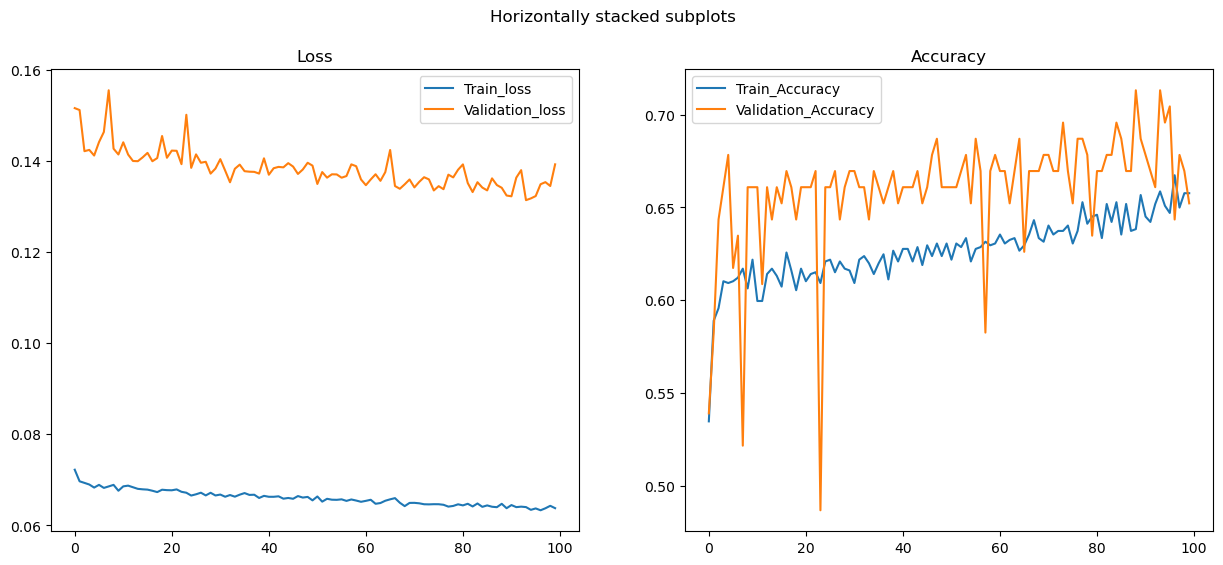

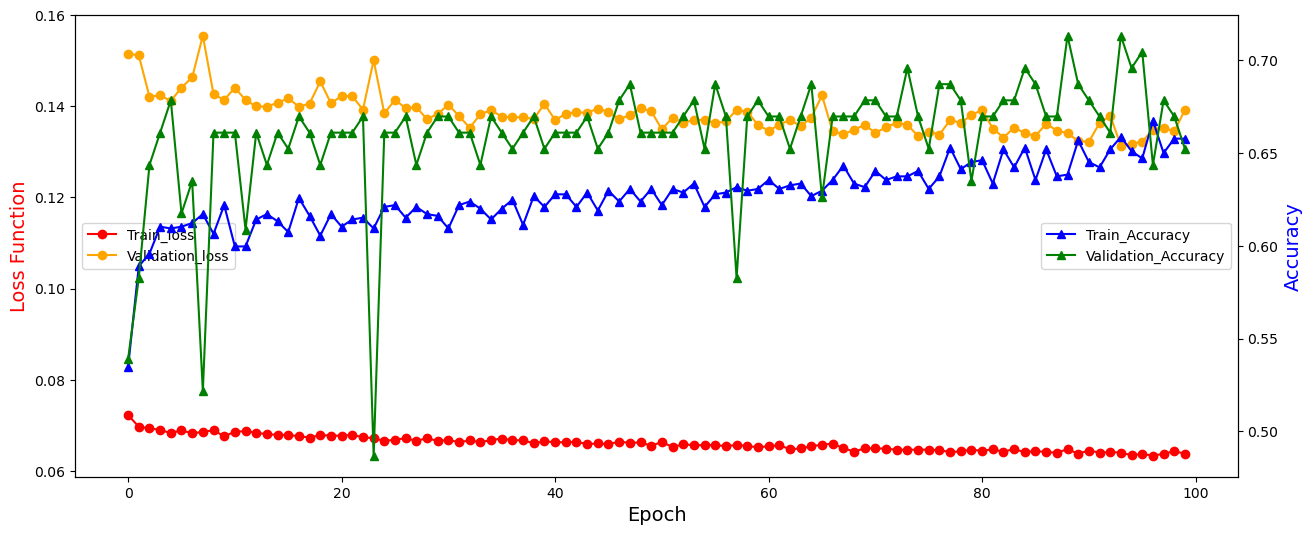

Current time: 75.471 minutes. Time expected till completion: 301.883 minutes

Epoch 101 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06345204983043486
Val loss:  0.13557834625244142
train accuracy:  0.6644100580270793
Val accuracy:  0.591304347826087
Current time: 76.196 minutes. Time expected till completion: 301.012 minutes

Epoch 102 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06375513950676245
Val loss:  0.13761827582898348
train accuracy:  0.6508704061895552
Val accuracy:  0.6608695652173913
Current time: 76.924 minutes. Time expected till completion: 300.153 minutes

Epoch 103 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.06295394159608468
Val loss:  0.13538279222405475
train accuracy:  0.6624758220502901
Val accuracy:  0.6956521739130435
Current time: 77.650 minutes. Time expected till completion: 299.293 minutes

Epoch 104 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06333893255062215
Val loss:  0.13801994531050973
train accuracy:  0.6576402321083172
Val accuracy:  0.6608695652173913
Current time: 78.377 minutes. Time expected till completion: 298.436 minutes

Epoch 105 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06351471500654977
Val loss:  0.1323938945065374
train accuracy:  0.6479690522243714
Val accuracy:  0.6608695652173913
Current time: 79.106 minutes. Time expected till completion: 297.588 minutes

Epoch 106 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06333498636574073
Val loss:  0.13792676977489304
train accuracy:  0.6624758220502901
Val accuracy:  0.6695652173913044
Current time: 79.834 minutes. Time expected till completion: 296.740 minutes

Epoch 107 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06310862654412969
Val loss:  0.1352452516555786
train accuracy:  0.6624758220502901
Val accuracy:  0.6521739130434783
Current time: 80.560 minutes. Time expected till completion: 295.889 minutes

Epoch 108 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.0634239174180612
Val loss:  0.13649210515229598
train accuracy:  0.6547388781431335
Val accuracy:  0.6695652173913044
Current time: 81.289 minutes. Time expected till completion: 295.049 minutes

Epoch 109 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06358641979772764
Val loss:  0.13395738446194191
train accuracy:  0.6634429400386848
Val accuracy:  0.6695652173913044
Current time: 82.017 minutes. Time expected till completion: 294.208 minutes

Epoch 110 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.06371936588268907
Val loss:  0.14120630077693774
train accuracy:  0.6595744680851063
Val accuracy:  0.6173913043478261
Current time: 82.746 minutes. Time expected till completion: 293.372 minutes

Epoch 111 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06380034357712855
Val loss:  0.14082656528638757
train accuracy:  0.6740812379110251
Val accuracy:  0.6608695652173913
Current time: 83.472 minutes. Time expected till completion: 292.528 minutes

Epoch 112 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0626831613264877
Val loss:  0.1356504279634227
train accuracy:  0.6760154738878144
Val accuracy:  0.6782608695652174
Current time: 84.203 minutes. Time expected till completion: 291.703 minutes

Epoch 113 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06246521083252573
Val loss:  0.13560403533603835
train accuracy:  0.6827852998065764
Val accuracy:  0.7304347826086957
Current time: 84.931 minutes. Time expected till completion: 290.871 minutes

Epoch 114 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.06291258214059604
Val loss:  0.13881157792132834
train accuracy:  0.6673114119922631
Val accuracy:  0.6173913043478261
Current time: 85.659 minutes. Time expected till completion: 290.039 minutes

Epoch 115 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06283440759380274
Val loss:  0.1349240277124488
train accuracy:  0.6595744680851063
Val accuracy:  0.6434782608695652
Current time: 86.387 minutes. Time expected till completion: 289.207 minutes

Epoch 116 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06296987488606451
Val loss:  0.1353609033252882
train accuracy:  0.6731141199226306
Val accuracy:  0.6695652173913044
Current time: 87.115 minutes. Time expected till completion: 288.381 minutes

Epoch 117 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06338060513225238
Val loss:  0.13557720132496046
train accuracy:  0.6663442940038685
Val accuracy:  0.6782608695652174
Current time: 87.842 minutes. Time expected till completion: 287.551 minutes

Epoch 118 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.062215539715045655
Val loss:  0.13961225385251252
train accuracy:  0.688588007736944
Val accuracy:  0.6521739130434783
Current time: 88.570 minutes. Time expected till completion: 286.727 minutes

Epoch 119 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06346416761612293
Val loss:  0.13499998372534047
train accuracy:  0.6663442940038685
Val accuracy:  0.6782608695652174
Current time: 89.303 minutes. Time expected till completion: 285.919 minutes

Epoch 120 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0631423223064762
Val loss:  0.13675277647764786
train accuracy:  0.6760154738878144
Val accuracy:  0.6521739130434783
Current time: 90.032 minutes. Time expected till completion: 285.100 minutes

Epoch 121 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06233154390028874
Val loss:  0.13407789313274882
train accuracy:  0.683752417794971
Val accuracy:  0.6956521739130435
Current time: 90.758 minutes. Time expected till completion: 284.276 minutes

Epoch 122 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.06195851503303941
Val loss:  0.13467045970585034
train accuracy:  0.6895551257253385
Val accuracy:  0.6695652173913044
Current time: 91.486 minutes. Time expected till completion: 283.457 minutes

Epoch 123 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06200806021229211
Val loss:  0.1330047887304555
train accuracy:  0.6914893617021277
Val accuracy:  0.6869565217391305
Current time: 92.214 minutes. Time expected till completion: 282.638 minutes

Epoch 124 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.062364612776260084
Val loss:  0.13412816990976748
train accuracy:  0.6808510638297872
Val accuracy:  0.6869565217391305
Current time: 92.944 minutes. Time expected till completion: 281.830 minutes

Epoch 125 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.062102813093528525
Val loss:  0.13400679930396703
train accuracy:  0.690522243713733
Val accuracy:  0.6782608695652174
Current time: 93.672 minutes. Time expected till completion: 281.017 minutes

Epoch 126 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.061890009869920444
Val loss:  0.13957390318746152
train accuracy:  0.7088974854932302
Val accuracy:  0.6782608695652174
Current time: 94.399 minutes. Time expected till completion: 280.201 minutes

Epoch 127 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06260424754375185
Val loss:  0.13754576185475226
train accuracy:  0.690522243713733
Val accuracy:  0.6956521739130435
Current time: 95.128 minutes. Time expected till completion: 279.391 minutes

Epoch 128 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.061921125627347993
Val loss:  0.13797381131545358
train accuracy:  0.6982591876208898
Val accuracy:  0.6782608695652174
Current time: 95.856 minutes. Time expected till completion: 278.582 minutes

Epoch 129 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.061901565850126905
Val loss:  0.13717321364775947
train accuracy:  0.6914893617021277
Val accuracy:  0.6260869565217392
Current time: 96.584 minutes. Time expected till completion: 277.773 minutes

Epoch 130 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.062409478068582325
Val loss:  0.13337418929390285
train accuracy:  0.6827852998065764
Val accuracy:  0.6956521739130435
Current time: 97.312 minutes. Time expected till completion: 276.964 minutes

Epoch 131 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06265476455540905
Val loss:  0.13303958851358164
train accuracy:  0.6895551257253385
Val accuracy:  0.7217391304347827
Current time: 98.041 minutes. Time expected till completion: 276.161 minutes

Epoch 132 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06275357245476611
Val loss:  0.13677863400915394
train accuracy:  0.6789168278529981
Val accuracy:  0.7217391304347827
Current time: 98.769 minutes. Time expected till completion: 275.355 minutes

Epoch 133 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.061347261618830015
Val loss:  0.1323980352152949
train accuracy:  0.7001934235976789
Val accuracy:  0.7130434782608696
Current time: 99.496 minutes. Time expected till completion: 274.549 minutes

Epoch 134 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.061948164807528086
Val loss:  0.13266240410182786
train accuracy:  0.6914893617021277
Val accuracy:  0.6869565217391305
Current time: 100.224 minutes. Time expected till completion: 273.747 minutes

Epoch 135 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06154829113810851
Val loss:  0.13226822562839674
train accuracy:  0.7021276595744681
Val accuracy:  0.6956521739130435
Current time: 100.954 minutes. Time expected till completion: 272.949 minutes

Epoch 136 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.06182732930266419
Val loss:  0.13306794011074563
train accuracy:  0.6972920696324951
Val accuracy:  0.6869565217391305
Current time: 101.683 minutes. Time expected till completion: 272.150 minutes

Epoch 137 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06245800812424267
Val loss:  0.1331022884534753
train accuracy:  0.6914893617021277
Val accuracy:  0.6956521739130435
Current time: 102.409 minutes. Time expected till completion: 271.346 minutes

Epoch 138 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0616561340985953
Val loss:  0.13341348482214888
train accuracy:  0.6934235976789168
Val accuracy:  0.6695652173913044
Current time: 103.136 minutes. Time expected till completion: 270.545 minutes

Epoch 139 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06086686155551638
Val loss:  0.13629328478937563
train accuracy:  0.7059961315280464
Val accuracy:  0.6869565217391305
Current time: 103.863 minutes. Time expected till completion: 269.746 minutes

Epoch 140 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.06278780840582267
Val loss:  0.13616171867951102
train accuracy:  0.6808510638297872
Val accuracy:  0.6608695652173913
Current time: 104.592 minutes. Time expected till completion: 268.950 minutes

Epoch 141 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.0617866618144443
Val loss:  0.13194399346476016
train accuracy:  0.7079303675048356
Val accuracy:  0.6695652173913044
Current time: 105.319 minutes. Time expected till completion: 268.154 minutes

Epoch 142 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06142822807254828
Val loss:  0.1372446956841842
train accuracy:  0.7079303675048356
Val accuracy:  0.6521739130434783
Current time: 106.047 minutes. Time expected till completion: 267.358 minutes

Epoch 143 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.062297801042202595
Val loss:  0.13536102512608403
train accuracy:  0.6934235976789168
Val accuracy:  0.6347826086956522
Current time: 106.775 minutes. Time expected till completion: 266.564 minutes

Epoch 144 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06233333682414411
Val loss:  0.13063333345496136
train accuracy:  0.6827852998065764
Val accuracy:  0.7043478260869566
Current time: 107.503 minutes. Time expected till completion: 265.771 minutes

Epoch 145 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06120749650886949
Val loss:  0.133781505667645
train accuracy:  0.7176015473887815
Val accuracy:  0.7217391304347827
Current time: 108.231 minutes. Time expected till completion: 264.979 minutes

Epoch 146 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06112167233424676
Val loss:  0.1513300895690918
train accuracy:  0.7147001934235977
Val accuracy:  0.5478260869565217
Current time: 108.963 minutes. Time expected till completion: 264.198 minutes

Epoch 147 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.06261178856892097
Val loss:  0.1326563290927721
train accuracy:  0.6818181818181818
Val accuracy:  0.7043478260869566
Current time: 109.691 minutes. Time expected till completion: 263.408 minutes

Epoch 148 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.061534496006237005
Val loss:  0.13400654637295267
train accuracy:  0.7214700193423598
Val accuracy:  0.6782608695652174
Current time: 110.420 minutes. Time expected till completion: 262.621 minutes

Epoch 149 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06168228774052294
Val loss:  0.13211093778195587
train accuracy:  0.6943907156673114
Val accuracy:  0.7217391304347827
Current time: 111.147 minutes. Time expected till completion: 261.829 minutes

Epoch 150 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06076985384324994
Val loss:  0.13660004864568295
train accuracy:  0.7166344294003868
Val accuracy:  0.6608695652173913
Current time: 111.876 minutes. Time expected till completion: 261.043 minutes

Epoch 151 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.061653028777305115
Val loss:  0.1328238984812861
train accuracy:  0.6943907156673114
Val accuracy:  0.7130434782608696
Current time: 112.605 minutes. Time expected till completion: 260.260 minutes

Epoch 152 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0610146263120714
Val loss:  0.1304299945416658
train accuracy:  0.7127659574468085
Val accuracy:  0.7043478260869566
Current time: 113.335 minutes. Time expected till completion: 259.476 minutes

Epoch 153 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06117491392379112
Val loss:  0.13375393981518952
train accuracy:  0.7040618955512572
Val accuracy:  0.6869565217391305
Current time: 114.065 minutes. Time expected till completion: 258.695 minutes

Epoch 154 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06064452014762613
Val loss:  0.1333633303642273
train accuracy:  0.7156673114119922
Val accuracy:  0.6956521739130435
Current time: 114.793 minutes. Time expected till completion: 257.912 minutes

Epoch 155 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.060571058806413836
Val loss:  0.1348882960236591
train accuracy:  0.7224371373307543
Val accuracy:  0.6956521739130435
Current time: 115.520 minutes. Time expected till completion: 257.125 minutes

Epoch 156 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.061436903084730966
Val loss:  0.13434881749360458
train accuracy:  0.7098646034816247
Val accuracy:  0.6521739130434783
Current time: 116.248 minutes. Time expected till completion: 256.343 minutes

Epoch 157 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06074795876296392
Val loss:  0.1370080626529196
train accuracy:  0.7147001934235977
Val accuracy:  0.6782608695652174
Current time: 116.977 minutes. Time expected till completion: 255.560 minutes

Epoch 158 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.060527471958783885
Val loss:  0.1381597586300062
train accuracy:  0.7263056092843327
Val accuracy:  0.6782608695652174
Current time: 117.705 minutes. Time expected till completion: 254.778 minutes

Epoch 159 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06094087622843582
Val loss:  0.13251219676888507
train accuracy:  0.7195357833655706
Val accuracy:  0.6782608695652174
Current time: 118.431 minutes. Time expected till completion: 253.994 minutes

Epoch 160 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.06040852235871542
Val loss:  0.13621567643207053
train accuracy:  0.7292069632495164
Val accuracy:  0.6608695652173913
Current time: 119.161 minutes. Time expected till completion: 253.218 minutes

Epoch 161 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0610478070188076
Val loss:  0.13658440268558006
train accuracy:  0.7127659574468085
Val accuracy:  0.6434782608695652
Current time: 119.888 minutes. Time expected till completion: 252.436 minutes

Epoch 162 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.06013147201482747
Val loss:  0.13623123376265817
train accuracy:  0.7253384912959381
Val accuracy:  0.6782608695652174
Current time: 120.617 minutes. Time expected till completion: 251.659 minutes

Epoch 163 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06115737822576925
Val loss:  0.13592834368995999
train accuracy:  0.7098646034816247
Val accuracy:  0.6608695652173913
Current time: 121.343 minutes. Time expected till completion: 250.876 minutes

Epoch 164 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06035591757043879
Val loss:  0.13278278008751246
train accuracy:  0.718568665377176
Val accuracy:  0.6782608695652174
Current time: 122.072 minutes. Time expected till completion: 250.098 minutes

Epoch 165 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.06053073735947304
Val loss:  0.13651300772376682
train accuracy:  0.7224371373307543
Val accuracy:  0.6434782608695652
Current time: 122.798 minutes. Time expected till completion: 249.317 minutes

Epoch 166 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06068106442401672
Val loss:  0.13831972039264182
train accuracy:  0.7205029013539652
Val accuracy:  0.6173913043478261
Current time: 123.528 minutes. Time expected till completion: 248.544 minutes

Epoch 167 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05990897098869604
Val loss:  0.137052161278932
train accuracy:  0.730174081237911
Val accuracy:  0.6347826086956522
Current time: 124.256 minutes. Time expected till completion: 247.768 minutes

Epoch 168 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06098560086763113
Val loss:  0.13558466641799263
train accuracy:  0.706963249516441
Val accuracy:  0.6608695652173913
Current time: 124.983 minutes. Time expected till completion: 246.990 minutes

Epoch 169 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.060433576485174535
Val loss:  0.14114704650381338
train accuracy:  0.723404255319149
Val accuracy:  0.6434782608695652
Current time: 125.710 minutes. Time expected till completion: 246.212 minutes

Epoch 170 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0602156287005146
Val loss:  0.13507481191469276
train accuracy:  0.7156673114119922
Val accuracy:  0.6608695652173913
Current time: 126.437 minutes. Time expected till completion: 245.436 minutes

Epoch 171 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.059957869278854284
Val loss:  0.13923312943914662
train accuracy:  0.7195357833655706
Val accuracy:  0.6086956521739131
Current time: 127.165 minutes. Time expected till completion: 244.663 minutes

Epoch 172 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.06027502945590065
Val loss:  0.14026190612627112
train accuracy:  0.7166344294003868
Val accuracy:  0.6434782608695652
Current time: 127.893 minutes. Time expected till completion: 243.889 minutes

Epoch 173 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.060097319014528965
Val loss:  0.13302086643550706
train accuracy:  0.730174081237911
Val accuracy:  0.6869565217391305
Current time: 128.622 minutes. Time expected till completion: 243.117 minutes

Epoch 174 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.06015130958197426
Val loss:  0.13563336289447286
train accuracy:  0.7340425531914894
Val accuracy:  0.6695652173913044
Current time: 129.348 minutes. Time expected till completion: 242.342 minutes

Epoch 175 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.059986555311158735
Val loss:  0.14041943550109864
train accuracy:  0.7224371373307543
Val accuracy:  0.6173913043478261
Current time: 130.076 minutes. Time expected till completion: 241.570 minutes

Epoch 176 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05927394800306058
Val loss:  0.13422411110090174
train accuracy:  0.7437137330754352
Val accuracy:  0.7043478260869566
Current time: 130.804 minutes. Time expected till completion: 240.797 minutes

Epoch 177 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05977455911368881
Val loss:  0.14056188282759294
train accuracy:  0.7475822050290135
Val accuracy:  0.5739130434782609
Current time: 131.530 minutes. Time expected till completion: 240.024 minutes

Epoch 178 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.06025323081523814
Val loss:  0.1381135531093763
train accuracy:  0.7330754352030948
Val accuracy:  0.7043478260869566
Current time: 132.258 minutes. Time expected till completion: 239.253 minutes

Epoch 179 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05936461738968264
Val loss:  0.1374767339747885
train accuracy:  0.7601547388781431
Val accuracy:  0.6260869565217392
Current time: 132.986 minutes. Time expected till completion: 238.483 minutes

Epoch 180 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05946044615205068
Val loss:  0.132788260086723
train accuracy:  0.741779497098646
Val accuracy:  0.6869565217391305
Current time: 133.713 minutes. Time expected till completion: 237.712 minutes

Epoch 181 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.059101594601193984
Val loss:  0.1362608007762743
train accuracy:  0.7495164410058027
Val accuracy:  0.6869565217391305
Current time: 134.440 minutes. Time expected till completion: 236.940 minutes

Epoch 182 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05942724302151678
Val loss:  0.13251647223596988
train accuracy:  0.7388781431334622
Val accuracy:  0.6956521739130435
Current time: 135.168 minutes. Time expected till completion: 236.172 minutes

Epoch 183 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05956514568808462
Val loss:  0.1344028555828592
train accuracy:  0.7456479690522244
Val accuracy:  0.6521739130434783
Current time: 135.896 minutes. Time expected till completion: 235.405 minutes

Epoch 184 of 500


100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


train loss:  0.059429292752618254
Val loss:  0.1358520025792329
train accuracy:  0.7456479690522244
Val accuracy:  0.6434782608695652
Current time: 136.624 minutes. Time expected till completion: 234.637 minutes

Epoch 185 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.058904832059686836
Val loss:  0.1295768546021503
train accuracy:  0.7369439071566731
Val accuracy:  0.7130434782608696
Current time: 137.352 minutes. Time expected till completion: 233.870 minutes

Epoch 186 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05929648167160079
Val loss:  0.1347812383071236
train accuracy:  0.7475822050290135
Val accuracy:  0.6695652173913044
Current time: 138.080 minutes. Time expected till completion: 233.103 minutes

Epoch 187 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05907403927015382
Val loss:  0.13724209795827452
train accuracy:  0.7495164410058027
Val accuracy:  0.6782608695652174
Current time: 138.810 minutes. Time expected till completion: 232.340 minutes

Epoch 188 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05976675476741975
Val loss:  0.12881998912147855
train accuracy:  0.7398452611218569
Val accuracy:  0.6956521739130435
Current time: 139.537 minutes. Time expected till completion: 231.572 minutes

Epoch 189 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05941331663260838
Val loss:  0.13210674990778384
train accuracy:  0.730174081237911
Val accuracy:  0.7391304347826086
Current time: 140.265 minutes. Time expected till completion: 230.807 minutes

Epoch 190 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05892172617192886
Val loss:  0.12940558609755143
train accuracy:  0.7456479690522244
Val accuracy:  0.6956521739130435
Current time: 140.994 minutes. Time expected till completion: 230.043 minutes

Epoch 191 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05889790235681737
Val loss:  0.136442202070485
train accuracy:  0.7524177949709865
Val accuracy:  0.6521739130434783
Current time: 141.722 minutes. Time expected till completion: 229.278 minutes

Epoch 192 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.060441566850968444
Val loss:  0.1336992051290429
train accuracy:  0.723404255319149
Val accuracy:  0.6956521739130435
Current time: 142.451 minutes. Time expected till completion: 228.516 minutes

Epoch 193 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05868975884448629
Val loss:  0.13350239888481472
train accuracy:  0.7630560928433269
Val accuracy:  0.7043478260869566
Current time: 143.181 minutes. Time expected till completion: 227.753 minutes

Epoch 194 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.059475702520034764
Val loss:  0.13388828609300696
train accuracy:  0.7427466150870407
Val accuracy:  0.6521739130434783
Current time: 143.910 minutes. Time expected till completion: 226.991 minutes

Epoch 195 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05867649565812928
Val loss:  0.13589804172515868
train accuracy:  0.758220502901354
Val accuracy:  0.6608695652173913
Current time: 144.637 minutes. Time expected till completion: 226.227 minutes

Epoch 196 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05925178372191276
Val loss:  0.13509083312490713
train accuracy:  0.7524177949709865
Val accuracy:  0.6869565217391305
Current time: 145.364 minutes. Time expected till completion: 225.462 minutes

Epoch 197 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0591169720230988
Val loss:  0.1324809432029724
train accuracy:  0.7620889748549323
Val accuracy:  0.6695652173913044
Current time: 146.093 minutes. Time expected till completion: 224.701 minutes

Epoch 198 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.059697891688208514
Val loss:  0.13268276349357935
train accuracy:  0.7282398452611218
Val accuracy:  0.6956521739130435
Current time: 146.823 minutes. Time expected till completion: 223.942 minutes

Epoch 199 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.05926793502423934
Val loss:  0.1347768933876701
train accuracy:  0.7495164410058027
Val accuracy:  0.6782608695652174
Current time: 147.551 minutes. Time expected till completion: 223.181 minutes

Epoch 200 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.0587742880303809
Val loss:  0.13445526361465454
train accuracy:  0.7475822050290135
Val accuracy:  0.6782608695652174
Saving model checkpoint


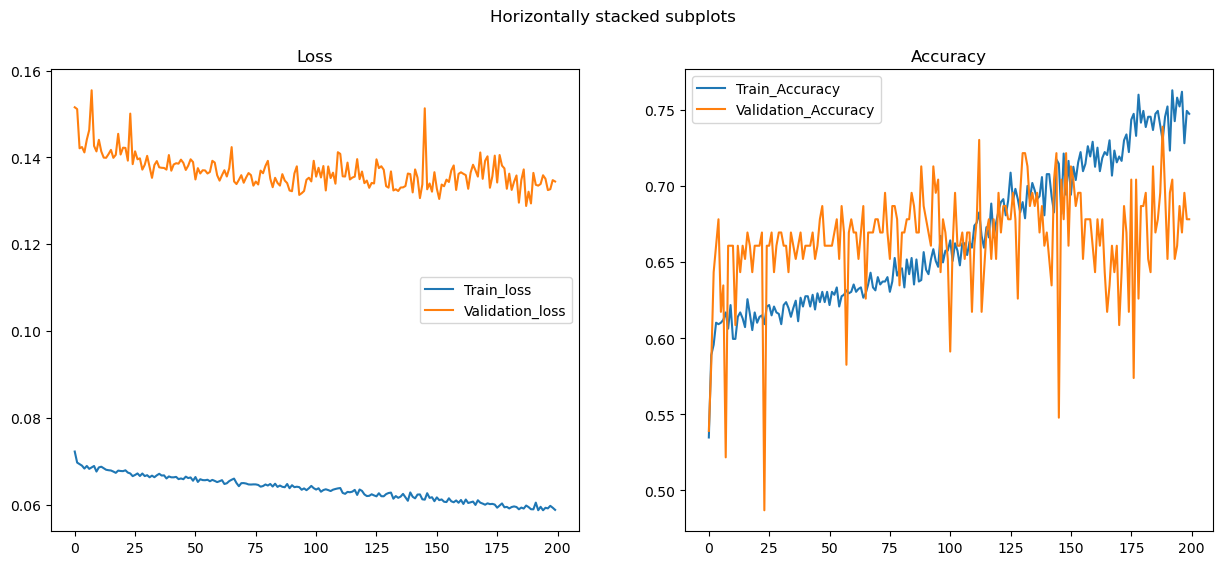

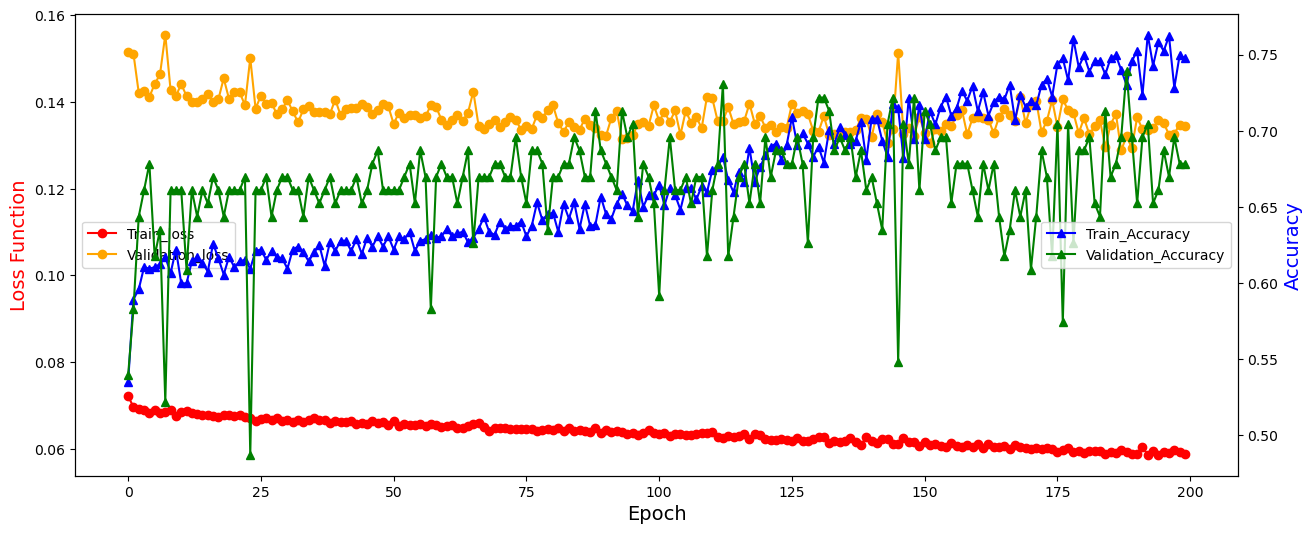

Current time: 148.302 minutes. Time expected till completion: 222.453 minutes

Epoch 201 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05908781756976587
Val loss:  0.13264342598293138
train accuracy:  0.7562862669245648
Val accuracy:  0.6782608695652174
Current time: 149.033 minutes. Time expected till completion: 221.695 minutes

Epoch 202 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05900239235427901
Val loss:  0.1357406776884328
train accuracy:  0.758220502901354
Val accuracy:  0.6695652173913044
Current time: 149.761 minutes. Time expected till completion: 220.934 minutes

Epoch 203 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05892529017228914
Val loss:  0.1380870751712633
train accuracy:  0.7678916827852998
Val accuracy:  0.6260869565217392
Current time: 150.489 minutes. Time expected till completion: 220.173 minutes

Epoch 204 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05894653427070529
Val loss:  0.13784989896027938
train accuracy:  0.7553191489361702
Val accuracy:  0.6869565217391305
Current time: 151.216 minutes. Time expected till completion: 219.411 minutes

Epoch 205 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05910284618344482
Val loss:  0.13978309372197026
train accuracy:  0.7649903288201161
Val accuracy:  0.6695652173913044
Current time: 151.945 minutes. Time expected till completion: 218.652 minutes

Epoch 206 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.06009861429148071
Val loss:  0.1317067115203194
train accuracy:  0.7485493230174082
Val accuracy:  0.7043478260869566
Current time: 152.674 minutes. Time expected till completion: 217.894 minutes

Epoch 207 of 500


100%|██████████| 15/15 [00:02<00:00,  6.37it/s]


train loss:  0.058987383051582645
Val loss:  0.1391997622407001
train accuracy:  0.7591876208897486
Val accuracy:  0.6869565217391305
Current time: 153.403 minutes. Time expected till completion: 217.136 minutes

Epoch 208 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05918173904114581
Val loss:  0.13644232231637707
train accuracy:  0.7601547388781431
Val accuracy:  0.6521739130434783
Current time: 154.133 minutes. Time expected till completion: 216.379 minutes

Epoch 209 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05924749310980452
Val loss:  0.13491622624189958
train accuracy:  0.7669245647969052
Val accuracy:  0.6695652173913044
Current time: 154.862 minutes. Time expected till completion: 215.622 minutes

Epoch 210 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0590075568027607
Val loss:  0.13504462967748226
train accuracy:  0.7601547388781431
Val accuracy:  0.6956521739130435
Current time: 155.591 minutes. Time expected till completion: 214.863 minutes

Epoch 211 of 500


100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


train loss:  0.05827157490488639
Val loss:  0.1307796820350315
train accuracy:  0.7727272727272727
Val accuracy:  0.7391304347826086
Current time: 156.318 minutes. Time expected till completion: 214.104 minutes

Epoch 212 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.058315064505866696
Val loss:  0.13356905812802522
train accuracy:  0.7794970986460348
Val accuracy:  0.7043478260869566
Current time: 157.045 minutes. Time expected till completion: 213.344 minutes

Epoch 213 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.058246271234416405
Val loss:  0.12967162235923435
train accuracy:  0.7727272727272727
Val accuracy:  0.6956521739130435
Current time: 157.773 minutes. Time expected till completion: 212.586 minutes

Epoch 214 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05889407958929036
Val loss:  0.1303732675054799
train accuracy:  0.7620889748549323
Val accuracy:  0.6782608695652174
Current time: 158.500 minutes. Time expected till completion: 211.827 minutes

Epoch 215 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05866561832926029
Val loss:  0.13672948661057846
train accuracy:  0.7775628626692457
Val accuracy:  0.6782608695652174
Current time: 159.228 minutes. Time expected till completion: 211.070 minutes

Epoch 216 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05770031470855846
Val loss:  0.13654589290204255
train accuracy:  0.7940038684719536
Val accuracy:  0.6869565217391305
Current time: 159.956 minutes. Time expected till completion: 210.313 minutes

Epoch 217 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.059318230507221625
Val loss:  0.13385004323461783
train accuracy:  0.7456479690522244
Val accuracy:  0.6956521739130435
Current time: 160.684 minutes. Time expected till completion: 209.556 minutes

Epoch 218 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.0582496178565219
Val loss:  0.1349096521087315
train accuracy:  0.7678916827852998
Val accuracy:  0.6956521739130435
Current time: 161.411 minutes. Time expected till completion: 208.798 minutes

Epoch 219 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05751912373638707
Val loss:  0.13235708734263543
train accuracy:  0.7920696324951644
Val accuracy:  0.6869565217391305
Current time: 162.137 minutes. Time expected till completion: 208.039 minutes

Epoch 220 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.057860088071693995
Val loss:  0.13457025341365647
train accuracy:  0.781431334622824
Val accuracy:  0.6608695652173913
Current time: 162.866 minutes. Time expected till completion: 207.284 minutes

Epoch 221 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05828180292358251
Val loss:  0.13579532374506412
train accuracy:  0.7630560928433269
Val accuracy:  0.7130434782608696
Current time: 163.596 minutes. Time expected till completion: 206.530 minutes

Epoch 222 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.05815601233587505
Val loss:  0.1358480883681256
train accuracy:  0.7746615087040619
Val accuracy:  0.6608695652173913
Current time: 164.323 minutes. Time expected till completion: 205.773 minutes

Epoch 223 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05762639647526252
Val loss:  0.13225082677343616
train accuracy:  0.7785299806576402
Val accuracy:  0.6695652173913044
Current time: 165.050 minutes. Time expected till completion: 205.017 minutes

Epoch 224 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05809592001673331
Val loss:  0.13061907757883487
train accuracy:  0.7862669245647969
Val accuracy:  0.7391304347826086
Current time: 165.776 minutes. Time expected till completion: 204.260 minutes

Epoch 225 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05747420126049846
Val loss:  0.1335418084393377
train accuracy:  0.7911025145067698
Val accuracy:  0.7217391304347827
Current time: 166.505 minutes. Time expected till completion: 203.506 minutes

Epoch 226 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05735245629482159
Val loss:  0.13491105826004693
train accuracy:  0.7920696324951644
Val accuracy:  0.6956521739130435
Current time: 167.233 minutes. Time expected till completion: 202.751 minutes

Epoch 227 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05784029564036622
Val loss:  0.13275098593338677
train accuracy:  0.8036750483558994
Val accuracy:  0.7043478260869566
Current time: 167.961 minutes. Time expected till completion: 201.997 minutes

Epoch 228 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05750339992733481
Val loss:  0.138848164288894
train accuracy:  0.8056092843326886
Val accuracy:  0.6173913043478261
Current time: 168.691 minutes. Time expected till completion: 201.245 minutes

Epoch 229 of 500


100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


train loss:  0.058292717260364404
Val loss:  0.1304840969002765
train accuracy:  0.7988394584139265
Val accuracy:  0.7478260869565218
Current time: 169.421 minutes. Time expected till completion: 200.494 minutes

Epoch 230 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05783478445886874
Val loss:  0.13778216061384782
train accuracy:  0.7949709864603481
Val accuracy:  0.6695652173913044
Current time: 170.150 minutes. Time expected till completion: 199.741 minutes

Epoch 231 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05819001257765455
Val loss:  0.1358709402706312
train accuracy:  0.7940038684719536
Val accuracy:  0.6608695652173913
Current time: 170.879 minutes. Time expected till completion: 198.989 minutes

Epoch 232 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.058537300942714254
Val loss:  0.13693150592886882
train accuracy:  0.7882011605415861
Val accuracy:  0.6695652173913044
Current time: 171.607 minutes. Time expected till completion: 198.236 minutes

Epoch 233 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.05850214129259785
Val loss:  0.13515360407207322
train accuracy:  0.7736943907156673
Val accuracy:  0.6869565217391305
Current time: 172.337 minutes. Time expected till completion: 197.485 minutes

Epoch 234 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05755393307951479
Val loss:  0.1387646353763083
train accuracy:  0.809477756286267
Val accuracy:  0.6521739130434783
Current time: 173.064 minutes. Time expected till completion: 196.731 minutes

Epoch 235 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0576945888004635
Val loss:  0.13619875493256942
train accuracy:  0.8065764023210832
Val accuracy:  0.6956521739130435
Current time: 173.792 minutes. Time expected till completion: 195.979 minutes

Epoch 236 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.057359322069691965
Val loss:  0.13805960935095082
train accuracy:  0.8056092843326886
Val accuracy:  0.6521739130434783
Current time: 174.518 minutes. Time expected till completion: 195.224 minutes

Epoch 237 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05695792565723914
Val loss:  0.13791746056598167
train accuracy:  0.8172147001934236
Val accuracy:  0.6608695652173913
Current time: 175.244 minutes. Time expected till completion: 194.469 minutes

Epoch 238 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.057077006571989226
Val loss:  0.13544556057971457
train accuracy:  0.8172147001934236
Val accuracy:  0.6782608695652174
Current time: 175.971 minutes. Time expected till completion: 193.716 minutes

Epoch 239 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05624954341919786
Val loss:  0.13588258960972663
train accuracy:  0.8355899419729207
Val accuracy:  0.6956521739130435
Current time: 176.699 minutes. Time expected till completion: 192.964 minutes

Epoch 240 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05664703105819525
Val loss:  0.1410370666047801
train accuracy:  0.8268858800773694
Val accuracy:  0.6347826086956522
Current time: 177.427 minutes. Time expected till completion: 192.213 minutes

Epoch 241 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05690623909177356
Val loss:  0.1372002601623535
train accuracy:  0.8278529980657641
Val accuracy:  0.6869565217391305
Current time: 178.155 minutes. Time expected till completion: 191.461 minutes

Epoch 242 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05741059693653763
Val loss:  0.14336651770964912
train accuracy:  0.8056092843326886
Val accuracy:  0.6086956521739131
Current time: 178.883 minutes. Time expected till completion: 190.710 minutes

Epoch 243 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.057953291116876804
Val loss:  0.1423465609550476
train accuracy:  0.7978723404255319
Val accuracy:  0.6260869565217392
Current time: 179.611 minutes. Time expected till completion: 189.959 minutes

Epoch 244 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05655355535346719
Val loss:  0.1386862091396166
train accuracy:  0.8307543520309478
Val accuracy:  0.6521739130434783
Current time: 180.338 minutes. Time expected till completion: 189.208 minutes

Epoch 245 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05666171155538503
Val loss:  0.1378977148429207
train accuracy:  0.8133462282398453
Val accuracy:  0.6434782608695652
Current time: 181.067 minutes. Time expected till completion: 188.458 minutes

Epoch 246 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.056698507220417665
Val loss:  0.14172669182653014
train accuracy:  0.8268858800773694
Val accuracy:  0.6173913043478261
Current time: 181.797 minutes. Time expected till completion: 187.709 minutes

Epoch 247 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0574095699381321
Val loss:  0.14206420805143274
train accuracy:  0.811411992263056
Val accuracy:  0.6173913043478261
Current time: 182.525 minutes. Time expected till completion: 186.959 minutes

Epoch 248 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05626644295004397
Val loss:  0.14491982304531595
train accuracy:  0.8355899419729207
Val accuracy:  0.6347826086956522
Current time: 183.253 minutes. Time expected till completion: 186.208 minutes

Epoch 249 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.057902811574290294
Val loss:  0.13868367309155671
train accuracy:  0.8143133462282398
Val accuracy:  0.6869565217391305
Current time: 183.980 minutes. Time expected till completion: 185.458 minutes

Epoch 250 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05677585606418219
Val loss:  0.134795604063117
train accuracy:  0.8210831721470019
Val accuracy:  0.6782608695652174
Current time: 184.709 minutes. Time expected till completion: 184.709 minutes

Epoch 251 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05691011131847389
Val loss:  0.13529702321342799
train accuracy:  0.8085106382978723
Val accuracy:  0.7043478260869566
Current time: 185.435 minutes. Time expected till completion: 183.957 minutes

Epoch 252 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05633632887724059
Val loss:  0.1408458279526752
train accuracy:  0.8336557059961315
Val accuracy:  0.6521739130434783
Current time: 186.163 minutes. Time expected till completion: 183.208 minutes

Epoch 253 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05620744132672795
Val loss:  0.13826279173726622
train accuracy:  0.8288201160541586
Val accuracy:  0.6782608695652174
Current time: 186.891 minutes. Time expected till completion: 182.459 minutes

Epoch 254 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.057075428028862986
Val loss:  0.13724366426467896
train accuracy:  0.8056092843326886
Val accuracy:  0.6956521739130435
Current time: 187.619 minutes. Time expected till completion: 181.710 minutes

Epoch 255 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05625335921171325
Val loss:  0.13819503628689309
train accuracy:  0.8249516441005803
Val accuracy:  0.6608695652173913
Current time: 188.345 minutes. Time expected till completion: 180.959 minutes

Epoch 256 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05667481852453959
Val loss:  0.14090158939361572
train accuracy:  0.8259187620889749
Val accuracy:  0.591304347826087
Current time: 189.076 minutes. Time expected till completion: 180.213 minutes

Epoch 257 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05668620116706051
Val loss:  0.13757589226183684
train accuracy:  0.8278529980657641
Val accuracy:  0.6695652173913044
Current time: 189.803 minutes. Time expected till completion: 179.463 minutes

Epoch 258 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05643652572622613
Val loss:  0.13658827906069548
train accuracy:  0.8355899419729207
Val accuracy:  0.6695652173913044
Current time: 190.530 minutes. Time expected till completion: 178.714 minutes

Epoch 259 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.05726356495971606
Val loss:  0.1339709997177124
train accuracy:  0.8123791102514507
Val accuracy:  0.6956521739130435
Current time: 191.258 minutes. Time expected till completion: 177.966 minutes

Epoch 260 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05657437045984619
Val loss:  0.13549754567768263
train accuracy:  0.8201160541586073
Val accuracy:  0.6869565217391305
Current time: 191.984 minutes. Time expected till completion: 177.216 minutes

Epoch 261 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0562748023573619
Val loss:  0.1380192668541618
train accuracy:  0.8288201160541586
Val accuracy:  0.6260869565217392
Current time: 192.712 minutes. Time expected till completion: 176.468 minutes

Epoch 262 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.056003544789448925
Val loss:  0.1361233001169951
train accuracy:  0.8346228239845261
Val accuracy:  0.6695652173913044
Current time: 193.438 minutes. Time expected till completion: 175.719 minutes

Epoch 263 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05612837132678963
Val loss:  0.1393030664195185
train accuracy:  0.8336557059961315
Val accuracy:  0.6521739130434783
Current time: 194.167 minutes. Time expected till completion: 174.972 minutes

Epoch 264 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05554744393728688
Val loss:  0.13886031741681307
train accuracy:  0.851063829787234
Val accuracy:  0.6782608695652174
Current time: 194.896 minutes. Time expected till completion: 174.225 minutes

Epoch 265 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05652314551333164
Val loss:  0.13495447117349377
train accuracy:  0.8278529980657641
Val accuracy:  0.6608695652173913
Current time: 195.625 minutes. Time expected till completion: 173.479 minutes

Epoch 266 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.055472682015808225
Val loss:  0.13550313762996508
train accuracy:  0.8462282398452611
Val accuracy:  0.6434782608695652
Current time: 196.354 minutes. Time expected till completion: 172.733 minutes

Epoch 267 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05665609563342377
Val loss:  0.1357920035071995
train accuracy:  0.8317214700193424
Val accuracy:  0.6869565217391305
Current time: 197.083 minutes. Time expected till completion: 171.986 minutes

Epoch 268 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05660466823863799
Val loss:  0.1382329692011294
train accuracy:  0.8268858800773694
Val accuracy:  0.6608695652173913
Current time: 197.811 minutes. Time expected till completion: 171.240 minutes

Epoch 269 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05583662642039921
Val loss:  0.14390661820121434
train accuracy:  0.8413926499032882
Val accuracy:  0.591304347826087
Current time: 198.540 minutes. Time expected till completion: 170.493 minutes

Epoch 270 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.0553354602487221
Val loss:  0.14314861401267673
train accuracy:  0.8529980657640233
Val accuracy:  0.591304347826087
Current time: 199.271 minutes. Time expected till completion: 169.749 minutes

Epoch 271 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05641382442682809
Val loss:  0.13634379480196082
train accuracy:  0.8307543520309478
Val accuracy:  0.6695652173913044
Current time: 199.999 minutes. Time expected till completion: 169.003 minutes

Epoch 272 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.05491261688606882
Val loss:  0.1442824275597282
train accuracy:  0.8558994197292069
Val accuracy:  0.6173913043478261
Current time: 200.727 minutes. Time expected till completion: 168.257 minutes

Epoch 273 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05514136660029856
Val loss:  0.1431169945260753
train accuracy:  0.8529980657640233
Val accuracy:  0.6086956521739131
Current time: 201.454 minutes. Time expected till completion: 167.510 minutes

Epoch 274 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05509449123644506
Val loss:  0.13691808088966037
train accuracy:  0.8568665377176016
Val accuracy:  0.6521739130434783
Current time: 202.187 minutes. Time expected till completion: 166.768 minutes

Epoch 275 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05546498926972513
Val loss:  0.1402573144954184
train accuracy:  0.8452611218568665
Val accuracy:  0.6434782608695652
Current time: 202.917 minutes. Time expected till completion: 166.023 minutes

Epoch 276 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.054636697819892395
Val loss:  0.13860390082649562
train accuracy:  0.8607350096711799
Val accuracy:  0.6956521739130435
Current time: 203.646 minutes. Time expected till completion: 165.278 minutes

Epoch 277 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.055815270433573476
Val loss:  0.13876032155493032
train accuracy:  0.8375241779497099
Val accuracy:  0.6695652173913044
Current time: 204.374 minutes. Time expected till completion: 164.532 minutes

Epoch 278 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05635675355590289
Val loss:  0.13247448205947876
train accuracy:  0.8210831721470019
Val accuracy:  0.6869565217391305
Current time: 205.103 minutes. Time expected till completion: 163.787 minutes

Epoch 279 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.055513810777110796
Val loss:  0.14129263836404551
train accuracy:  0.8529980657640233
Val accuracy:  0.6260869565217392
Current time: 205.831 minutes. Time expected till completion: 163.042 minutes

Epoch 280 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.055033349206876477
Val loss:  0.1376136012699293
train accuracy:  0.8481624758220503
Val accuracy:  0.6434782608695652
Current time: 206.560 minutes. Time expected till completion: 162.297 minutes

Epoch 281 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05491046708372622
Val loss:  0.1393092912176381
train accuracy:  0.851063829787234
Val accuracy:  0.6695652173913044
Current time: 207.288 minutes. Time expected till completion: 161.552 minutes

Epoch 282 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05485480216762314
Val loss:  0.13760215355002361
train accuracy:  0.8655705996131529
Val accuracy:  0.6695652173913044
Current time: 208.015 minutes. Time expected till completion: 160.806 minutes

Epoch 283 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.055248280558410884
Val loss:  0.1421247741450434
train accuracy:  0.8500967117988395
Val accuracy:  0.6260869565217392
Current time: 208.742 minutes. Time expected till completion: 160.061 minutes

Epoch 284 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05564610876243857
Val loss:  0.13782817021660182
train accuracy:  0.8413926499032882
Val accuracy:  0.6869565217391305
Current time: 209.470 minutes. Time expected till completion: 159.315 minutes

Epoch 285 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.054885976146222086
Val loss:  0.14092017982317054
train accuracy:  0.8578336557059961
Val accuracy:  0.6173913043478261
Current time: 210.198 minutes. Time expected till completion: 158.571 minutes

Epoch 286 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05472667339461454
Val loss:  0.13800019595933996
train accuracy:  0.8549323017408124
Val accuracy:  0.6086956521739131
Current time: 210.927 minutes. Time expected till completion: 157.826 minutes

Epoch 287 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.054908030383591495
Val loss:  0.13344647417897765
train accuracy:  0.8568665377176016
Val accuracy:  0.6956521739130435
Current time: 211.655 minutes. Time expected till completion: 157.082 minutes

Epoch 288 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.054215688885295876
Val loss:  0.14692851253177808
train accuracy:  0.8762088974854932
Val accuracy:  0.5739130434782609
Current time: 212.385 minutes. Time expected till completion: 156.339 minutes

Epoch 289 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05464306738897726
Val loss:  0.13851309859234354
train accuracy:  0.867504835589942
Val accuracy:  0.6521739130434783
Current time: 213.112 minutes. Time expected till completion: 155.594 minutes

Epoch 290 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.054718291390564736
Val loss:  0.1348528582116832
train accuracy:  0.8607350096711799
Val accuracy:  0.6782608695652174
Current time: 213.841 minutes. Time expected till completion: 154.850 minutes

Epoch 291 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.0542611724749294
Val loss:  0.1366565403730973
train accuracy:  0.8713733075435203
Val accuracy:  0.6782608695652174
Current time: 214.568 minutes. Time expected till completion: 154.106 minutes

Epoch 292 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.054545831057734834
Val loss:  0.13643059471379157
train accuracy:  0.8636363636363636
Val accuracy:  0.6695652173913044
Current time: 215.295 minutes. Time expected till completion: 153.361 minutes

Epoch 293 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05539953501127675
Val loss:  0.1396141855613045
train accuracy:  0.8520309477756286
Val accuracy:  0.6347826086956522
Current time: 216.022 minutes. Time expected till completion: 152.616 minutes

Epoch 294 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05487184079518862
Val loss:  0.14324917326802794
train accuracy:  0.8549323017408124
Val accuracy:  0.6
Current time: 216.750 minutes. Time expected till completion: 151.873 minutes

Epoch 295 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.054678164033410165
Val loss:  0.14188795711683191
train accuracy:  0.8636363636363636
Val accuracy:  0.6434782608695652
Current time: 217.479 minutes. Time expected till completion: 151.129 minutes

Epoch 296 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05423567915331695
Val loss:  0.13821900409200918
train accuracy:  0.8733075435203095
Val accuracy:  0.6782608695652174
Current time: 218.205 minutes. Time expected till completion: 150.384 minutes

Epoch 297 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.054286343562533826
Val loss:  0.13591777967370075
train accuracy:  0.8713733075435203
Val accuracy:  0.6782608695652174
Current time: 218.932 minutes. Time expected till completion: 149.640 minutes

Epoch 298 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.054631937115058676
Val loss:  0.14109822718993478
train accuracy:  0.8636363636363636
Val accuracy:  0.6521739130434783
Current time: 219.661 minutes. Time expected till completion: 148.897 minutes

Epoch 299 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.054703469087353525
Val loss:  0.13685997569042704
train accuracy:  0.8655705996131529
Val accuracy:  0.6956521739130435
Current time: 220.388 minutes. Time expected till completion: 148.154 minutes

Epoch 300 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.056045253571965936
Val loss:  0.13564839881399404
train accuracy:  0.839458413926499
Val accuracy:  0.6695652173913044
Saving model checkpoint


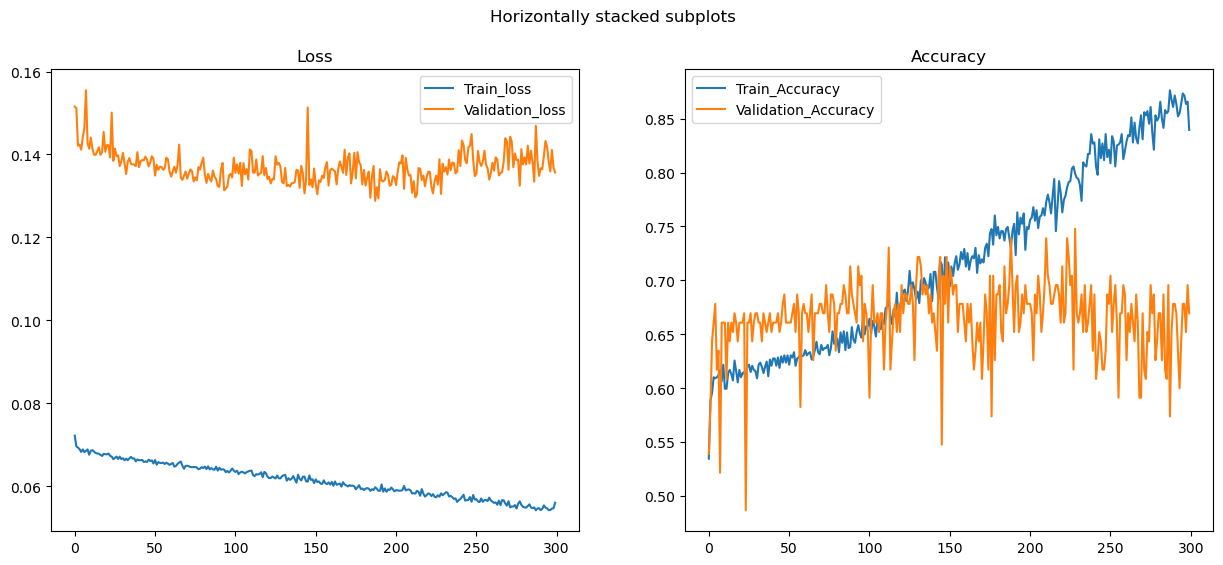

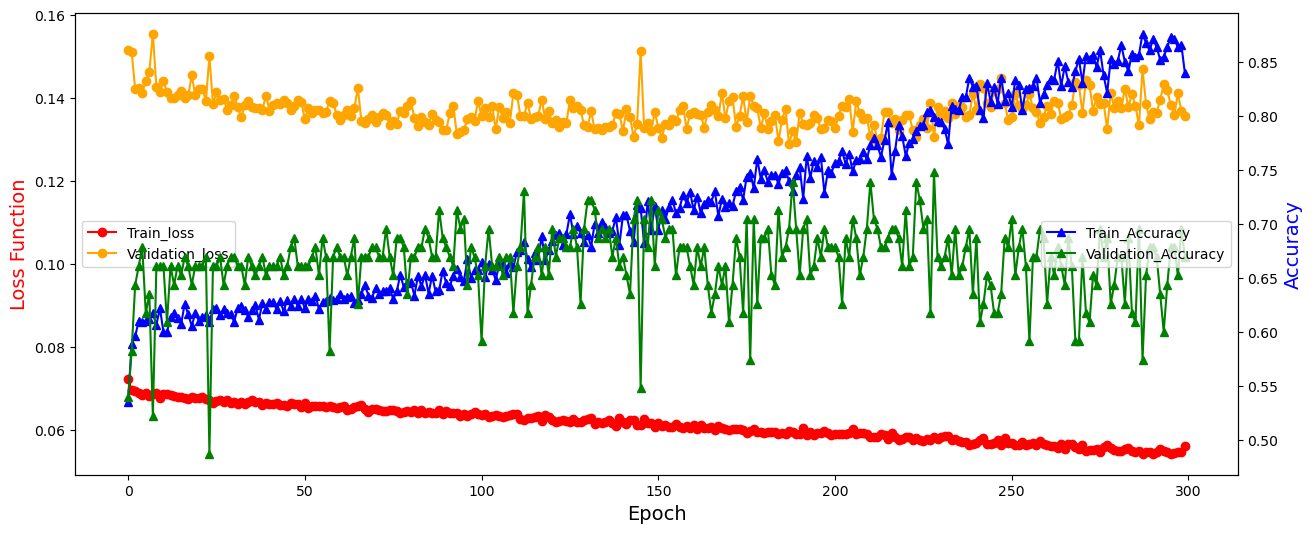

Current time: 221.137 minutes. Time expected till completion: 147.425 minutes

Epoch 301 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0539549416222932
Val loss:  0.14759743939275327
train accuracy:  0.8781431334622823
Val accuracy:  0.5652173913043478
Current time: 221.871 minutes. Time expected till completion: 146.685 minutes

Epoch 302 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.0534350099024044
Val loss:  0.13975783068200817
train accuracy:  0.8887814313346228
Val accuracy:  0.6695652173913044
Current time: 222.599 minutes. Time expected till completion: 145.942 minutes

Epoch 303 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05462970234439267
Val loss:  0.13733545541763306
train accuracy:  0.8607350096711799
Val accuracy:  0.6521739130434783
Current time: 223.327 minutes. Time expected till completion: 145.199 minutes

Epoch 304 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05461761828086824
Val loss:  0.13544196667878525
train accuracy:  0.8694390715667312
Val accuracy:  0.6869565217391305
Current time: 224.053 minutes. Time expected till completion: 144.456 minutes

Epoch 305 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.055329150687795085
Val loss:  0.1415030510529228
train accuracy:  0.8500967117988395
Val accuracy:  0.6173913043478261
Current time: 224.782 minutes. Time expected till completion: 143.713 minutes

Epoch 306 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05474624274085984
Val loss:  0.1434319133343904
train accuracy:  0.8607350096711799
Val accuracy:  0.6260869565217392
Current time: 225.509 minutes. Time expected till completion: 142.970 minutes

Epoch 307 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.053674132611811504
Val loss:  0.14094464830730272
train accuracy:  0.8781431334622823
Val accuracy:  0.6434782608695652
Current time: 226.238 minutes. Time expected till completion: 142.228 minutes

Epoch 308 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05420895638502774
Val loss:  0.13640968644100687
train accuracy:  0.8771760154738878
Val accuracy:  0.6695652173913044
Current time: 226.964 minutes. Time expected till completion: 141.484 minutes

Epoch 309 of 500


100%|██████████| 15/15 [00:02<00:00,  6.39it/s]


train loss:  0.05396780089206806
Val loss:  0.1451132738071939
train accuracy:  0.8849129593810445
Val accuracy:  0.6086956521739131
Current time: 227.696 minutes. Time expected till completion: 140.744 minutes

Epoch 310 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.054261069406162606
Val loss:  0.13823094005170075
train accuracy:  0.8762088974854932
Val accuracy:  0.6608695652173913
Current time: 228.429 minutes. Time expected till completion: 140.005 minutes

Epoch 311 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05460874324149274
Val loss:  0.13703010963357012
train accuracy:  0.8636363636363636
Val accuracy:  0.6869565217391305
Current time: 229.159 minutes. Time expected till completion: 139.264 minutes

Epoch 312 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.053920760606658756
Val loss:  0.1450066721957663
train accuracy:  0.8820116054158608
Val accuracy:  0.6086956521739131
Current time: 229.887 minutes. Time expected till completion: 138.522 minutes

Epoch 313 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05445272266518908
Val loss:  0.13697787056798522
train accuracy:  0.8665377176015474
Val accuracy:  0.6782608695652174
Current time: 230.616 minutes. Time expected till completion: 137.780 minutes

Epoch 314 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05301627291932097
Val loss:  0.13965424351070238
train accuracy:  0.8955512572533849
Val accuracy:  0.6434782608695652
Current time: 231.345 minutes. Time expected till completion: 137.039 minutes

Epoch 315 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.05360589215326586
Val loss:  0.1403967225033304
train accuracy:  0.8858800773694391
Val accuracy:  0.6434782608695652
Current time: 232.073 minutes. Time expected till completion: 136.297 minutes

Epoch 316 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05414712112000648
Val loss:  0.1429554856341818
train accuracy:  0.867504835589942
Val accuracy:  0.6173913043478261
Current time: 232.801 minutes. Time expected till completion: 135.555 minutes

Epoch 317 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.05507045396292002
Val loss:  0.14172479277071745
train accuracy:  0.851063829787234
Val accuracy:  0.6173913043478261
Current time: 233.531 minutes. Time expected till completion: 134.814 minutes

Epoch 318 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0538313124235179
Val loss:  0.13897487132445627
train accuracy:  0.8771760154738878
Val accuracy:  0.6608695652173913
Current time: 234.260 minutes. Time expected till completion: 134.073 minutes

Epoch 319 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05388914368599942
Val loss:  0.1364815986674765
train accuracy:  0.8781431334622823
Val accuracy:  0.6695652173913044
Current time: 234.988 minutes. Time expected till completion: 133.332 minutes

Epoch 320 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05382414701137137
Val loss:  0.14094234549480936
train accuracy:  0.8810444874274661
Val accuracy:  0.6434782608695652
Current time: 235.716 minutes. Time expected till completion: 132.590 minutes

Epoch 321 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.053536685223275045
Val loss:  0.14378727104352867
train accuracy:  0.8858800773694391
Val accuracy:  0.6
Current time: 236.445 minutes. Time expected till completion: 131.849 minutes

Epoch 322 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05334891981266914
Val loss:  0.14207401534785394
train accuracy:  0.8878143133462283
Val accuracy:  0.6260869565217392
Current time: 237.175 minutes. Time expected till completion: 131.109 minutes

Epoch 323 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.052605994031323225
Val loss:  0.1457603402759718
train accuracy:  0.8965183752417795
Val accuracy:  0.5826086956521739
Current time: 237.904 minutes. Time expected till completion: 130.368 minutes

Epoch 324 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.053004458806039746
Val loss:  0.1425678709278936
train accuracy:  0.8916827852998066
Val accuracy:  0.6086956521739131
Current time: 238.632 minutes. Time expected till completion: 129.627 minutes

Epoch 325 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.0530813557151669
Val loss:  0.1406145816263945
train accuracy:  0.8897485493230174
Val accuracy:  0.6608695652173913
Current time: 239.360 minutes. Time expected till completion: 128.886 minutes

Epoch 326 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05257278744210588
Val loss:  0.1434435901434525
train accuracy:  0.9061895551257253
Val accuracy:  0.6173913043478261
Current time: 240.089 minutes. Time expected till completion: 128.145 minutes

Epoch 327 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05345400879645947
Val loss:  0.14117635229359501
train accuracy:  0.8839458413926499
Val accuracy:  0.6521739130434783
Current time: 240.817 minutes. Time expected till completion: 127.405 minutes

Epoch 328 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05270907813160747
Val loss:  0.14080236683721128
train accuracy:  0.8984526112185687
Val accuracy:  0.6173913043478261
Current time: 241.547 minutes. Time expected till completion: 126.665 minutes

Epoch 329 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05299100804375034
Val loss:  0.14334651439086252
train accuracy:  0.9003868471953579
Val accuracy:  0.6347826086956522
Current time: 242.279 minutes. Time expected till completion: 125.926 minutes

Epoch 330 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.05302740175212144
Val loss:  0.1428197109180948
train accuracy:  0.8936170212765957
Val accuracy:  0.6347826086956522
Current time: 243.009 minutes. Time expected till completion: 125.187 minutes

Epoch 331 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05313906517434627
Val loss:  0.14769797376964403
train accuracy:  0.8916827852998066
Val accuracy:  0.591304347826087
Current time: 243.743 minutes. Time expected till completion: 124.449 minutes

Epoch 332 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.054000619762870745
Val loss:  0.1397655735845151
train accuracy:  0.8713733075435203
Val accuracy:  0.6347826086956522
Current time: 244.470 minutes. Time expected till completion: 123.708 minutes

Epoch 333 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05371973247085365
Val loss:  0.13820865776227867
train accuracy:  0.8829787234042553
Val accuracy:  0.6608695652173913
Current time: 245.198 minutes. Time expected till completion: 122.967 minutes

Epoch 334 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05314242626527753
Val loss:  0.14208146541014963
train accuracy:  0.8907156673114119
Val accuracy:  0.6521739130434783
Current time: 245.928 minutes. Time expected till completion: 122.228 minutes

Epoch 335 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05312811798007161
Val loss:  0.14216176530589228
train accuracy:  0.8858800773694391
Val accuracy:  0.6173913043478261
Current time: 246.657 minutes. Time expected till completion: 121.488 minutes

Epoch 336 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0531587687175094
Val loss:  0.14736259450083194
train accuracy:  0.8897485493230174
Val accuracy:  0.591304347826087
Current time: 247.387 minutes. Time expected till completion: 120.748 minutes

Epoch 337 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05222233000069107
Val loss:  0.14401653279428897
train accuracy:  0.9158607350096711
Val accuracy:  0.6434782608695652
Current time: 248.115 minutes. Time expected till completion: 120.008 minutes

Epoch 338 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.052023738622665405
Val loss:  0.14144946492236593
train accuracy:  0.9042553191489362
Val accuracy:  0.6086956521739131
Current time: 248.846 minutes. Time expected till completion: 119.269 minutes

Epoch 339 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.053163854999745144
Val loss:  0.13958006941753884
train accuracy:  0.8936170212765957
Val accuracy:  0.6347826086956522
Current time: 249.575 minutes. Time expected till completion: 118.530 minutes

Epoch 340 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05331611477660026
Val loss:  0.14184542272401893
train accuracy:  0.8810444874274661
Val accuracy:  0.6
Current time: 250.303 minutes. Time expected till completion: 117.790 minutes

Epoch 341 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05322174431046388
Val loss:  0.1441980242729187
train accuracy:  0.8839458413926499
Val accuracy:  0.6260869565217392
Current time: 251.032 minutes. Time expected till completion: 117.050 minutes

Epoch 342 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.052789405997071555
Val loss:  0.13932396380797676
train accuracy:  0.8868471953578336
Val accuracy:  0.6347826086956522
Current time: 251.761 minutes. Time expected till completion: 116.311 minutes

Epoch 343 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05228036255854933
Val loss:  0.14148381481999936
train accuracy:  0.9110251450676983
Val accuracy:  0.6434782608695652
Current time: 252.491 minutes. Time expected till completion: 115.572 minutes

Epoch 344 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05195715815924123
Val loss:  0.13869431122489598
train accuracy:  0.9100580270793037
Val accuracy:  0.6695652173913044
Current time: 253.218 minutes. Time expected till completion: 114.832 minutes

Epoch 345 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05343772519949096
Val loss:  0.1395301253899284
train accuracy:  0.879110251450677
Val accuracy:  0.6956521739130435
Current time: 253.947 minutes. Time expected till completion: 114.092 minutes

Epoch 346 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05292724219927244
Val loss:  0.14114257926526277
train accuracy:  0.8907156673114119
Val accuracy:  0.6434782608695652
Current time: 254.674 minutes. Time expected till completion: 113.352 minutes

Epoch 347 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05202594341807485
Val loss:  0.13956045067828635
train accuracy:  0.9090909090909091
Val accuracy:  0.6608695652173913
Current time: 255.404 minutes. Time expected till completion: 112.613 minutes

Epoch 348 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05351678378577389
Val loss:  0.14202489438264265
train accuracy:  0.8849129593810445
Val accuracy:  0.6260869565217392
Current time: 256.135 minutes. Time expected till completion: 111.875 minutes

Epoch 349 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05285722161400019
Val loss:  0.1383419306381889
train accuracy:  0.8945841392649904
Val accuracy:  0.6521739130434783
Current time: 256.866 minutes. Time expected till completion: 111.137 minutes

Epoch 350 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05180768890583769
Val loss:  0.13609115559121837
train accuracy:  0.9119922630560928
Val accuracy:  0.6782608695652174
Current time: 257.595 minutes. Time expected till completion: 110.398 minutes

Epoch 351 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05162848552375513
Val loss:  0.15689831091010054
train accuracy:  0.9226305609284333
Val accuracy:  0.48695652173913045
Current time: 258.323 minutes. Time expected till completion: 109.659 minutes

Epoch 352 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05309453658485781
Val loss:  0.1464143727136695
train accuracy:  0.8887814313346228
Val accuracy:  0.5826086956521739
Current time: 259.055 minutes. Time expected till completion: 108.921 minutes

Epoch 353 of 500


100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


train loss:  0.05249392698073987
Val loss:  0.14897111498791238
train accuracy:  0.9013539651837524
Val accuracy:  0.5826086956521739
Current time: 259.791 minutes. Time expected till completion: 108.185 minutes

Epoch 354 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05310563861286156
Val loss:  0.14759335362392922
train accuracy:  0.8868471953578336
Val accuracy:  0.5826086956521739
Current time: 260.522 minutes. Time expected till completion: 107.447 minutes

Epoch 355 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.051982727168376486
Val loss:  0.13882691341897715
train accuracy:  0.9119922630560928
Val accuracy:  0.6695652173913044
Current time: 261.251 minutes. Time expected till completion: 106.708 minutes

Epoch 356 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05146025625603342
Val loss:  0.13954481352930484
train accuracy:  0.9226305609284333
Val accuracy:  0.6434782608695652
Current time: 261.979 minutes. Time expected till completion: 105.969 minutes

Epoch 357 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05199832185324663
Val loss:  0.14105901251668515
train accuracy:  0.9061895551257253
Val accuracy:  0.6347826086956522
Current time: 262.706 minutes. Time expected till completion: 105.230 minutes

Epoch 358 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05184173555162013
Val loss:  0.14164090208385302
train accuracy:  0.9177949709864603
Val accuracy:  0.6434782608695652
Current time: 263.434 minutes. Time expected till completion: 104.490 minutes

Epoch 359 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05336651938104537
Val loss:  0.14691039168316386
train accuracy:  0.8887814313346228
Val accuracy:  0.5739130434782609
Current time: 264.162 minutes. Time expected till completion: 103.752 minutes

Epoch 360 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05297904866576425
Val loss:  0.1412558597067128
train accuracy:  0.8887814313346228
Val accuracy:  0.6608695652173913
Current time: 264.892 minutes. Time expected till completion: 103.014 minutes

Epoch 361 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.052680535404087264
Val loss:  0.13710533276848172
train accuracy:  0.902321083172147
Val accuracy:  0.6608695652173913
Current time: 265.620 minutes. Time expected till completion: 102.275 minutes

Epoch 362 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05191237991045245
Val loss:  0.14696075657139654
train accuracy:  0.9158607350096711
Val accuracy:  0.5652173913043478
Current time: 266.349 minutes. Time expected till completion: 101.536 minutes

Epoch 363 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05162277247043366
Val loss:  0.14047542447629183
train accuracy:  0.9158607350096711
Val accuracy:  0.6347826086956522
Current time: 267.077 minutes. Time expected till completion: 100.798 minutes

Epoch 364 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05181029934717101
Val loss:  0.13944689190906026
train accuracy:  0.9158607350096711
Val accuracy:  0.6782608695652174
Current time: 267.805 minutes. Time expected till completion: 100.059 minutes

Epoch 365 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.051538022159377195
Val loss:  0.142723142064136
train accuracy:  0.9168278529980658
Val accuracy:  0.6086956521739131
Current time: 268.531 minutes. Time expected till completion: 99.320 minutes

Epoch 366 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.051711916404720434
Val loss:  0.14321542408155358
train accuracy:  0.9100580270793037
Val accuracy:  0.6434782608695652
Current time: 269.261 minutes. Time expected till completion: 98.582 minutes

Epoch 367 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.051563988974753845
Val loss:  0.14589422578397004
train accuracy:  0.9129593810444874
Val accuracy:  0.5739130434782609
Current time: 269.990 minutes. Time expected till completion: 97.844 minutes

Epoch 368 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05083025256946423
Val loss:  0.14467774733253147
train accuracy:  0.9352030947775629
Val accuracy:  0.6260869565217392
Current time: 270.717 minutes. Time expected till completion: 97.105 minutes

Epoch 369 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05126358289091453
Val loss:  0.14354170249856035
train accuracy:  0.9264990328820116
Val accuracy:  0.6173913043478261
Current time: 271.446 minutes. Time expected till completion: 96.367 minutes

Epoch 370 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05133152509565741
Val loss:  0.1466792220654695
train accuracy:  0.9197292069632496
Val accuracy:  0.6086956521739131
Current time: 272.172 minutes. Time expected till completion: 95.628 minutes

Epoch 371 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.051567409324461536
Val loss:  0.143676117192144
train accuracy:  0.9187620889748549
Val accuracy:  0.591304347826087
Current time: 272.902 minutes. Time expected till completion: 94.890 minutes

Epoch 372 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05200282523203173
Val loss:  0.14491576215495233
train accuracy:  0.90715667311412
Val accuracy:  0.6086956521739131
Current time: 273.633 minutes. Time expected till completion: 94.153 minutes

Epoch 373 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05160151937944055
Val loss:  0.14086582038713538
train accuracy:  0.9187620889748549
Val accuracy:  0.6434782608695652
Current time: 274.361 minutes. Time expected till completion: 93.415 minutes

Epoch 374 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.05178895540809263
Val loss:  0.14021466192991838
train accuracy:  0.9100580270793037
Val accuracy:  0.6434782608695652
Current time: 275.089 minutes. Time expected till completion: 92.677 minutes

Epoch 375 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05097060507916389
Val loss:  0.1456816123879474
train accuracy:  0.9323017408123792
Val accuracy:  0.6
Current time: 275.821 minutes. Time expected till completion: 91.940 minutes

Epoch 376 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05241653132945933
Val loss:  0.13657976233440897
train accuracy:  0.9032882011605415
Val accuracy:  0.6956521739130435
Current time: 276.549 minutes. Time expected till completion: 91.202 minutes

Epoch 377 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05187939162180548
Val loss:  0.14424417226210884
train accuracy:  0.9119922630560928
Val accuracy:  0.6
Current time: 277.278 minutes. Time expected till completion: 90.465 minutes

Epoch 378 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05189541760450175
Val loss:  0.15360487803168918
train accuracy:  0.9110251450676983
Val accuracy:  0.5130434782608696
Current time: 278.007 minutes. Time expected till completion: 89.727 minutes

Epoch 379 of 500


100%|██████████| 15/15 [00:02<00:00,  6.40it/s]


train loss:  0.05211365597621615
Val loss:  0.1428510862848033
train accuracy:  0.90715667311412
Val accuracy:  0.6347826086956522
Current time: 278.737 minutes. Time expected till completion: 88.990 minutes

Epoch 380 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05087906681361466
Val loss:  0.14322636023811672
train accuracy:  0.9352030947775629
Val accuracy:  0.6086956521739131
Current time: 279.465 minutes. Time expected till completion: 88.252 minutes

Epoch 381 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.051431794115837585
Val loss:  0.1391251237496086
train accuracy:  0.9187620889748549
Val accuracy:  0.6608695652173913
Current time: 280.193 minutes. Time expected till completion: 87.514 minutes

Epoch 382 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05075973785361653
Val loss:  0.13984405372453773
train accuracy:  0.9294003868471954
Val accuracy:  0.6260869565217392
Current time: 280.921 minutes. Time expected till completion: 86.777 minutes

Epoch 383 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.05189885663110006
Val loss:  0.13995121302811997
train accuracy:  0.90715667311412
Val accuracy:  0.6260869565217392
Current time: 281.653 minutes. Time expected till completion: 86.040 minutes

Epoch 384 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05205449289002778
Val loss:  0.14467297636944315
train accuracy:  0.913926499032882
Val accuracy:  0.6086956521739131
Current time: 282.382 minutes. Time expected till completion: 85.303 minutes

Epoch 385 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05218551877158292
Val loss:  0.14421346032101176
train accuracy:  0.90715667311412
Val accuracy:  0.6173913043478261
Current time: 283.109 minutes. Time expected till completion: 84.565 minutes

Epoch 386 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05226234644939637
Val loss:  0.14308008473852407
train accuracy:  0.9061895551257253
Val accuracy:  0.6347826086956522
Current time: 283.839 minutes. Time expected till completion: 83.828 minutes

Epoch 387 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05124947509405922
Val loss:  0.1450679167457249
train accuracy:  0.9245647969052224
Val accuracy:  0.591304347826087
Current time: 284.569 minutes. Time expected till completion: 83.091 minutes

Epoch 388 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.051232494168862615
Val loss:  0.1463380912075872
train accuracy:  0.9245647969052224
Val accuracy:  0.5826086956521739
Current time: 285.298 minutes. Time expected till completion: 82.354 minutes

Epoch 389 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05148234917301274
Val loss:  0.15298272474952365
train accuracy:  0.9197292069632496
Val accuracy:  0.5217391304347826
Current time: 286.028 minutes. Time expected till completion: 81.617 minutes

Epoch 390 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.05273103662109006
Val loss:  0.14156202596166859
train accuracy:  0.9032882011605415
Val accuracy:  0.6521739130434783
Current time: 286.756 minutes. Time expected till completion: 80.880 minutes

Epoch 391 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05132582409008329
Val loss:  0.1406095167864924
train accuracy:  0.9216634429400387
Val accuracy:  0.6347826086956522
Current time: 287.482 minutes. Time expected till completion: 80.142 minutes

Epoch 392 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.052613781891201174
Val loss:  0.13672614201255467
train accuracy:  0.8994197292069632
Val accuracy:  0.6434782608695652
Current time: 288.210 minutes. Time expected till completion: 79.405 minutes

Epoch 393 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05109390870053718
Val loss:  0.14269563892613288
train accuracy:  0.9168278529980658
Val accuracy:  0.6260869565217392
Current time: 288.942 minutes. Time expected till completion: 78.669 minutes

Epoch 394 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.050844058250320255
Val loss:  0.14553832593171492
train accuracy:  0.9323017408123792
Val accuracy:  0.6086956521739131
Current time: 289.669 minutes. Time expected till completion: 77.931 minutes

Epoch 395 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05065844102800469
Val loss:  0.13773411201394123
train accuracy:  0.9352030947775629
Val accuracy:  0.6782608695652174
Current time: 290.397 minutes. Time expected till completion: 77.194 minutes

Epoch 396 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.05078017325419752
Val loss:  0.13745130352351975
train accuracy:  0.9313346228239845
Val accuracy:  0.6869565217391305
Current time: 291.130 minutes. Time expected till completion: 76.458 minutes

Epoch 397 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0510437772167951
Val loss:  0.14129717039025347
train accuracy:  0.9284332688588007
Val accuracy:  0.6347826086956522
Current time: 291.858 minutes. Time expected till completion: 75.721 minutes

Epoch 398 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05129167823773058
Val loss:  0.14710762189782184
train accuracy:  0.9206963249516441
Val accuracy:  0.591304347826087
Current time: 292.585 minutes. Time expected till completion: 74.984 minutes

Epoch 399 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.0514844540124705
Val loss:  0.1396461326143016
train accuracy:  0.9158607350096711
Val accuracy:  0.6608695652173913
Current time: 293.314 minutes. Time expected till completion: 74.247 minutes

Epoch 400 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.05081183790468847
Val loss:  0.13904327672460806
train accuracy:  0.9332688588007737
Val accuracy:  0.6608695652173913
Saving model checkpoint


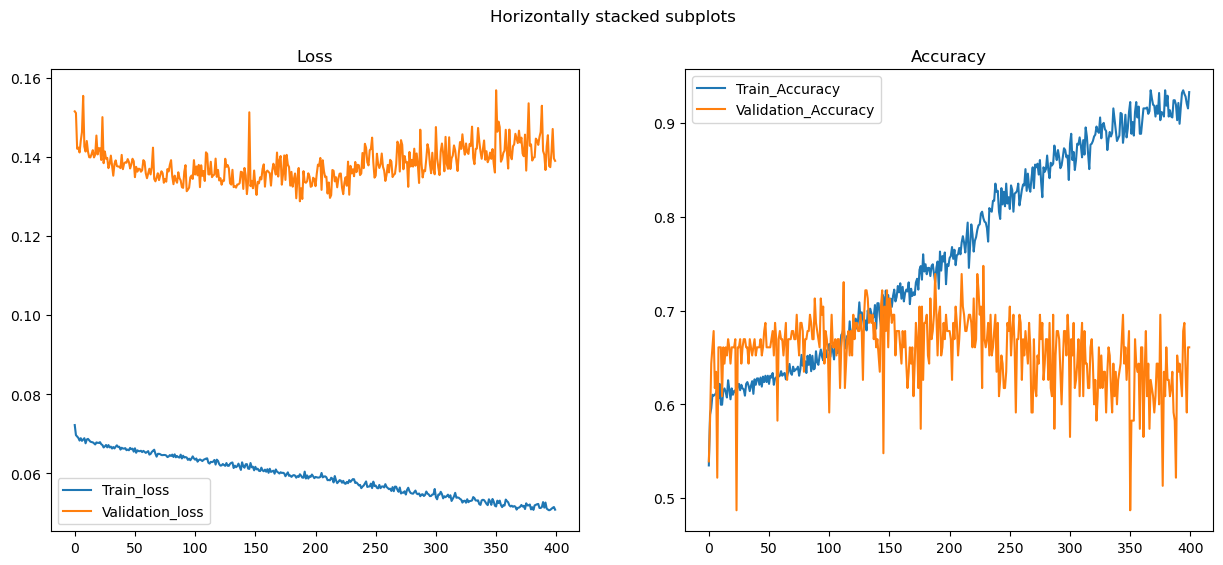

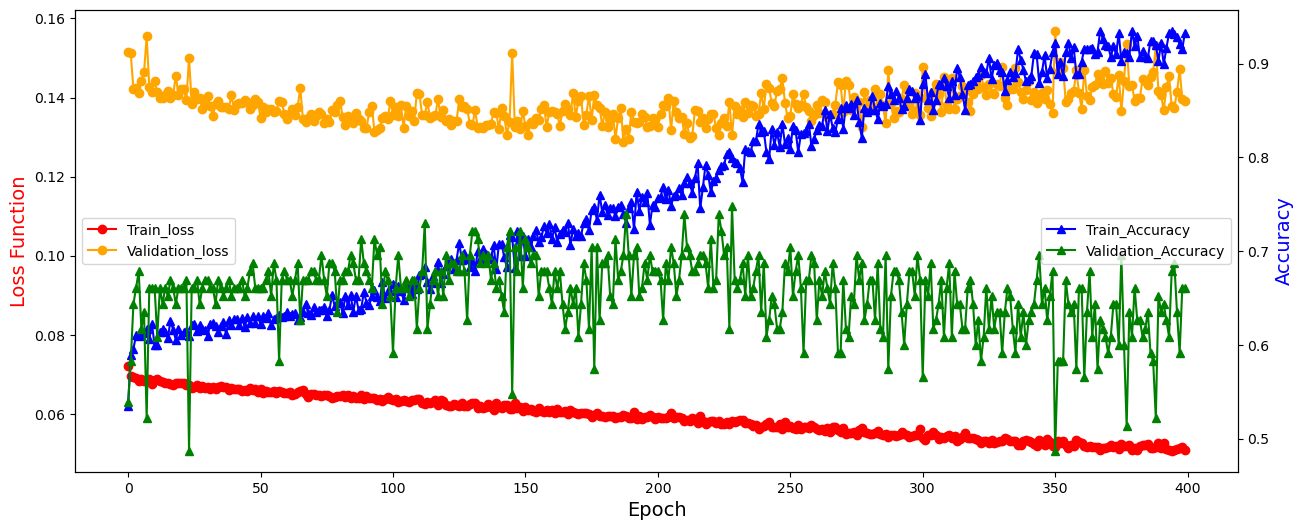

Current time: 294.065 minutes. Time expected till completion: 73.516 minutes

Epoch 401 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.0514018600752552
Val loss:  0.14099003439364227
train accuracy:  0.9235976789168279
Val accuracy:  0.6347826086956522
Current time: 294.795 minutes. Time expected till completion: 72.780 minutes

Epoch 402 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.051772001864139994
Val loss:  0.1435828887897989
train accuracy:  0.9090909090909091
Val accuracy:  0.6173913043478261
Current time: 295.522 minutes. Time expected till completion: 72.043 minutes

Epoch 403 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05078127000271928
Val loss:  0.137727835903997
train accuracy:  0.9323017408123792
Val accuracy:  0.6869565217391305
Current time: 296.251 minutes. Time expected till completion: 71.306 minutes

Epoch 404 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05131217681692924
Val loss:  0.15047264721082604
train accuracy:  0.9168278529980658
Val accuracy:  0.591304347826087
Current time: 296.980 minutes. Time expected till completion: 70.569 minutes

Epoch 405 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.051384451368560645
Val loss:  0.1481164776760599
train accuracy:  0.9245647969052224
Val accuracy:  0.5565217391304348
Current time: 297.710 minutes. Time expected till completion: 69.833 minutes

Epoch 406 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05089207555615925
Val loss:  0.1463351213413736
train accuracy:  0.9303675048355899
Val accuracy:  0.5826086956521739
Current time: 298.439 minutes. Time expected till completion: 69.097 minutes

Epoch 407 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.050294849351480805
Val loss:  0.14146953665691872
train accuracy:  0.9429400386847195
Val accuracy:  0.6608695652173913
Current time: 299.168 minutes. Time expected till completion: 68.360 minutes

Epoch 408 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0506905046376315
Val loss:  0.1422838060752205
train accuracy:  0.9332688588007737
Val accuracy:  0.6173913043478261
Current time: 299.896 minutes. Time expected till completion: 67.624 minutes

Epoch 409 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.04990160626645706
Val loss:  0.14535596215206645
train accuracy:  0.9468085106382979
Val accuracy:  0.6
Current time: 300.627 minutes. Time expected till completion: 66.888 minutes

Epoch 410 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.050908403712499536
Val loss:  0.1396292349566584
train accuracy:  0.9294003868471954
Val accuracy:  0.6521739130434783
Current time: 301.355 minutes. Time expected till completion: 66.151 minutes

Epoch 411 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05020967955976667
Val loss:  0.14539929058240808
train accuracy:  0.9468085106382979
Val accuracy:  0.6
Current time: 302.083 minutes. Time expected till completion: 65.415 minutes

Epoch 412 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.051051737492042996
Val loss:  0.14358255759529445
train accuracy:  0.9235976789168279
Val accuracy:  0.6173913043478261
Current time: 302.812 minutes. Time expected till completion: 64.678 minutes

Epoch 413 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.050404514692277004
Val loss:  0.1460586050282354
train accuracy:  0.9410058027079303
Val accuracy:  0.591304347826087
Current time: 303.540 minutes. Time expected till completion: 63.942 minutes

Epoch 414 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.050170070371037524
Val loss:  0.14537884100623752
train accuracy:  0.9410058027079303
Val accuracy:  0.6086956521739131
Current time: 304.268 minutes. Time expected till completion: 63.205 minutes

Epoch 415 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.04969271504440898
Val loss:  0.14385747857715772
train accuracy:  0.9506769825918762
Val accuracy:  0.6173913043478261
Current time: 304.997 minutes. Time expected till completion: 62.469 minutes

Epoch 416 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.050603898281746724
Val loss:  0.14354170198025912
train accuracy:  0.9352030947775629
Val accuracy:  0.6
Current time: 305.725 minutes. Time expected till completion: 61.733 minutes

Epoch 417 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05063303941914837
Val loss:  0.14396372152411419
train accuracy:  0.9303675048355899
Val accuracy:  0.6260869565217392
Current time: 306.452 minutes. Time expected till completion: 60.996 minutes

Epoch 418 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04995571494794215
Val loss:  0.1438223185746566
train accuracy:  0.9429400386847195
Val accuracy:  0.6173913043478261
Current time: 307.180 minutes. Time expected till completion: 60.260 minutes

Epoch 419 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05143243316524956
Val loss:  0.14257430200991422
train accuracy:  0.9177949709864603
Val accuracy:  0.6521739130434783
Current time: 307.910 minutes. Time expected till completion: 59.524 minutes

Epoch 420 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05032330768712485
Val loss:  0.1408024559850278
train accuracy:  0.9390715667311412
Val accuracy:  0.6521739130434783
Current time: 308.638 minutes. Time expected till completion: 58.788 minutes

Epoch 421 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05057030553052227
Val loss:  0.14223085901011592
train accuracy:  0.9390715667311412
Val accuracy:  0.6260869565217392
Current time: 309.365 minutes. Time expected till completion: 58.052 minutes

Epoch 422 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.050867327869053736
Val loss:  0.15239040903423143
train accuracy:  0.9352030947775629
Val accuracy:  0.5478260869565217
Current time: 310.094 minutes. Time expected till completion: 57.316 minutes

Epoch 423 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05073452652999465
Val loss:  0.14398585039636363
train accuracy:  0.9303675048355899
Val accuracy:  0.6173913043478261
Current time: 310.823 minutes. Time expected till completion: 56.580 minutes

Epoch 424 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.050205706685377965
Val loss:  0.14361102736514547
train accuracy:  0.941972920696325
Val accuracy:  0.6347826086956522
Current time: 311.552 minutes. Time expected till completion: 55.844 minutes

Epoch 425 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05026312152237219
Val loss:  0.14531870562097302
train accuracy:  0.9390715667311412
Val accuracy:  0.6173913043478261
Current time: 312.281 minutes. Time expected till completion: 55.108 minutes

Epoch 426 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.051276976181413955
Val loss:  0.14281410963638969
train accuracy:  0.9168278529980658
Val accuracy:  0.6
Current time: 313.009 minutes. Time expected till completion: 54.372 minutes

Epoch 427 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.050535337030311156
Val loss:  0.1453004759290944
train accuracy:  0.9352030947775629
Val accuracy:  0.6260869565217392
Current time: 313.740 minutes. Time expected till completion: 53.637 minutes

Epoch 428 of 500


100%|██████████| 15/15 [00:02<00:00,  6.41it/s]


train loss:  0.04974280168055566
Val loss:  0.14032249139702838
train accuracy:  0.9477756286266924
Val accuracy:  0.6434782608695652
Current time: 314.469 minutes. Time expected till completion: 52.901 minutes

Epoch 429 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05038325526036423
Val loss:  0.14295501294343368
train accuracy:  0.9390715667311412
Val accuracy:  0.6260869565217392
Current time: 315.196 minutes. Time expected till completion: 52.165 minutes

Epoch 430 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.04967387115701716
Val loss:  0.14346647625384124
train accuracy:  0.9458413926499033
Val accuracy:  0.6086956521739131
Current time: 315.924 minutes. Time expected till completion: 51.430 minutes

Epoch 431 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.04934544979488365
Val loss:  0.14221379549606986
train accuracy:  0.960348162475822
Val accuracy:  0.6173913043478261
Current time: 316.652 minutes. Time expected till completion: 50.694 minutes

Epoch 432 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04957706848703455
Val loss:  0.14527841754581616
train accuracy:  0.9535783365570599
Val accuracy:  0.6260869565217392
Current time: 317.379 minutes. Time expected till completion: 49.958 minutes

Epoch 433 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05010268472610636
Val loss:  0.150745225470999
train accuracy:  0.9448742746615088
Val accuracy:  0.5652173913043478
Current time: 318.107 minutes. Time expected till completion: 49.222 minutes

Epoch 434 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.049605245112911645
Val loss:  0.14477554663367895
train accuracy:  0.9535783365570599
Val accuracy:  0.6173913043478261
Current time: 318.835 minutes. Time expected till completion: 48.486 minutes

Epoch 435 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.05100056805739781
Val loss:  0.13716931705889496
train accuracy:  0.9352030947775629
Val accuracy:  0.6695652173913044
Current time: 319.566 minutes. Time expected till completion: 47.751 minutes

Epoch 436 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05048029444665005
Val loss:  0.1476965878320777
train accuracy:  0.9352030947775629
Val accuracy:  0.6
Current time: 320.292 minutes. Time expected till completion: 47.015 minutes

Epoch 437 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05059639455271413
Val loss:  0.14219123850698057
train accuracy:  0.937137330754352
Val accuracy:  0.6434782608695652
Current time: 321.020 minutes. Time expected till completion: 46.280 minutes

Epoch 438 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.0492762778552404
Val loss:  0.14181409089461616
train accuracy:  0.9632495164410058
Val accuracy:  0.6434782608695652
Current time: 321.750 minutes. Time expected till completion: 45.544 minutes

Epoch 439 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.05021637251575404
Val loss:  0.1464592353157375
train accuracy:  0.9429400386847195
Val accuracy:  0.6
Current time: 322.477 minutes. Time expected till completion: 44.809 minutes

Epoch 440 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.049957038413164005
Val loss:  0.1411703850912011
train accuracy:  0.9458413926499033
Val accuracy:  0.6521739130434783
Current time: 323.205 minutes. Time expected till completion: 44.073 minutes

Epoch 441 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.0502448552351164
Val loss:  0.1440728441528652
train accuracy:  0.9410058027079303
Val accuracy:  0.6173913043478261
Current time: 323.937 minutes. Time expected till completion: 43.339 minutes

Epoch 442 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.04965081505434195
Val loss:  0.14007580280303955
train accuracy:  0.9506769825918762
Val accuracy:  0.6608695652173913
Current time: 324.666 minutes. Time expected till completion: 42.603 minutes

Epoch 443 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04995127169260435
Val loss:  0.13581265729406605
train accuracy:  0.9468085106382979
Val accuracy:  0.6782608695652174
Current time: 325.396 minutes. Time expected till completion: 41.868 minutes

Epoch 444 of 500


100%|██████████| 15/15 [00:02<00:00,  6.53it/s]


train loss:  0.050370498482908914
Val loss:  0.14236902672311533
train accuracy:  0.9342359767891683
Val accuracy:  0.6347826086956522
Current time: 326.125 minutes. Time expected till completion: 41.133 minutes

Epoch 445 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05070263147354126
Val loss:  0.13535712179930315
train accuracy:  0.9303675048355899
Val accuracy:  0.6608695652173913
Current time: 326.854 minutes. Time expected till completion: 40.398 minutes

Epoch 446 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.050845396069078425
Val loss:  0.1465413238691247
train accuracy:  0.9294003868471954
Val accuracy:  0.6
Current time: 327.583 minutes. Time expected till completion: 39.662 minutes

Epoch 447 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.04992328270030437
Val loss:  0.14250540422356647
train accuracy:  0.9439071566731141
Val accuracy:  0.6347826086956522
Current time: 328.311 minutes. Time expected till completion: 38.927 minutes

Epoch 448 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.050842166581052416
Val loss:  0.14878634577212127
train accuracy:  0.9284332688588007
Val accuracy:  0.5652173913043478
Current time: 329.038 minutes. Time expected till completion: 38.192 minutes

Epoch 449 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05002762276383848
Val loss:  0.14804250312888104
train accuracy:  0.9458413926499033
Val accuracy:  0.5826086956521739
Current time: 329.766 minutes. Time expected till completion: 37.457 minutes

Epoch 450 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.049738169869325145
Val loss:  0.13781177064646846
train accuracy:  0.9497098646034816
Val accuracy:  0.6782608695652174
Current time: 330.497 minutes. Time expected till completion: 36.722 minutes

Epoch 451 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05029628038175793
Val loss:  0.1395776753840239
train accuracy:  0.937137330754352
Val accuracy:  0.6608695652173913
Current time: 331.223 minutes. Time expected till completion: 35.987 minutes

Epoch 452 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.049405253948049344
Val loss:  0.14214309091153352
train accuracy:  0.9574468085106383
Val accuracy:  0.6173913043478261
Current time: 331.952 minutes. Time expected till completion: 35.251 minutes

Epoch 453 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.049752657544912635
Val loss:  0.14066827660021575
train accuracy:  0.9506769825918762
Val accuracy:  0.6347826086956522
Current time: 332.679 minutes. Time expected till completion: 34.516 minutes

Epoch 454 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04984491919410528
Val loss:  0.14040002978366353
train accuracy:  0.9477756286266924
Val accuracy:  0.6521739130434783
Current time: 333.407 minutes. Time expected till completion: 33.781 minutes

Epoch 455 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04939603511553899
Val loss:  0.14159731813099075
train accuracy:  0.9584139264990329
Val accuracy:  0.6260869565217392
Current time: 334.136 minutes. Time expected till completion: 33.046 minutes

Epoch 456 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.04976621915800659
Val loss:  0.14429116352744725
train accuracy:  0.9497098646034816
Val accuracy:  0.6260869565217392
Current time: 334.864 minutes. Time expected till completion: 32.311 minutes

Epoch 457 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.04996261127451633
Val loss:  0.1413455517395683
train accuracy:  0.9448742746615088
Val accuracy:  0.6347826086956522
Current time: 335.593 minutes. Time expected till completion: 31.577 minutes

Epoch 458 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04998262246757227
Val loss:  0.1387621231701063
train accuracy:  0.9458413926499033
Val accuracy:  0.6608695652173913
Current time: 336.320 minutes. Time expected till completion: 30.842 minutes

Epoch 459 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.049510206313843425
Val loss:  0.14095826563627822
train accuracy:  0.9535783365570599
Val accuracy:  0.6434782608695652
Current time: 337.051 minutes. Time expected till completion: 30.107 minutes

Epoch 460 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.04960772654535231
Val loss:  0.13886506972105606
train accuracy:  0.9516441005802708
Val accuracy:  0.6782608695652174
Current time: 337.779 minutes. Time expected till completion: 29.372 minutes

Epoch 461 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.05064808763203353
Val loss:  0.15094170725863912
train accuracy:  0.9342359767891683
Val accuracy:  0.5652173913043478
Current time: 338.508 minutes. Time expected till completion: 28.637 minutes

Epoch 462 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04999554018909742
Val loss:  0.14196439670479816
train accuracy:  0.9487427466150871
Val accuracy:  0.6434782608695652
Current time: 339.237 minutes. Time expected till completion: 27.903 minutes

Epoch 463 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.050297554445451184
Val loss:  0.14040484480235887
train accuracy:  0.9458413926499033
Val accuracy:  0.6608695652173913
Current time: 339.966 minutes. Time expected till completion: 27.168 minutes

Epoch 464 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04919168554837284
Val loss:  0.14106152316798334
train accuracy:  0.9593810444874274
Val accuracy:  0.6608695652173913
Current time: 340.696 minutes. Time expected till completion: 26.433 minutes

Epoch 465 of 500


100%|██████████| 15/15 [00:02<00:00,  6.44it/s]


train loss:  0.050454932324429776
Val loss:  0.1417066796966221
train accuracy:  0.9313346228239845
Val accuracy:  0.6434782608695652
Current time: 341.426 minutes. Time expected till completion: 25.699 minutes

Epoch 466 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.049926141359819896
Val loss:  0.14229196724684343
train accuracy:  0.9487427466150871
Val accuracy:  0.6434782608695652
Current time: 342.154 minutes. Time expected till completion: 24.964 minutes

Epoch 467 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.04957789874399654
Val loss:  0.1415659785270691
train accuracy:  0.9555125725338491
Val accuracy:  0.6521739130434783
Current time: 342.885 minutes. Time expected till completion: 24.230 minutes

Epoch 468 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.051114127875757864
Val loss:  0.1413135476734327
train accuracy:  0.925531914893617
Val accuracy:  0.6260869565217392
Current time: 343.615 minutes. Time expected till completion: 23.495 minutes

Epoch 469 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.049672857878055976
Val loss:  0.14206283403479536
train accuracy:  0.9497098646034816
Val accuracy:  0.6434782608695652
Current time: 344.342 minutes. Time expected till completion: 22.760 minutes

Epoch 470 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.049289675642028304
Val loss:  0.14133478558581808
train accuracy:  0.9593810444874274
Val accuracy:  0.6608695652173913
Current time: 345.071 minutes. Time expected till completion: 22.026 minutes

Epoch 471 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.04949798857220367
Val loss:  0.14345090181931205
train accuracy:  0.9564796905222437
Val accuracy:  0.6347826086956522
Current time: 345.798 minutes. Time expected till completion: 21.291 minutes

Epoch 472 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.04952929467251038
Val loss:  0.14323858540991077
train accuracy:  0.9526112185686654
Val accuracy:  0.6086956521739131
Current time: 346.526 minutes. Time expected till completion: 20.557 minutes

Epoch 473 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04962202347454757
Val loss:  0.14034406257712323
train accuracy:  0.9526112185686654
Val accuracy:  0.6521739130434783
Current time: 347.254 minutes. Time expected till completion: 19.822 minutes

Epoch 474 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04960781595231947
Val loss:  0.1368875695311505
train accuracy:  0.9516441005802708
Val accuracy:  0.6869565217391305
Current time: 347.982 minutes. Time expected till completion: 19.088 minutes

Epoch 475 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.049330351258154305
Val loss:  0.13943417642427527
train accuracy:  0.960348162475822
Val accuracy:  0.6608695652173913
Current time: 348.710 minutes. Time expected till completion: 18.353 minutes

Epoch 476 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.04911616265889063
Val loss:  0.140247933242632
train accuracy:  0.9593810444874274
Val accuracy:  0.6695652173913044
Current time: 349.438 minutes. Time expected till completion: 17.619 minutes

Epoch 477 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04917989893162504
Val loss:  0.14385290042213772
train accuracy:  0.9593810444874274
Val accuracy:  0.6260869565217392
Current time: 350.165 minutes. Time expected till completion: 16.884 minutes

Epoch 478 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.04953551672874613
Val loss:  0.14145108409549878
train accuracy:  0.9545454545454546
Val accuracy:  0.6434782608695652
Current time: 350.894 minutes. Time expected till completion: 16.150 minutes

Epoch 479 of 500


100%|██████████| 15/15 [00:02<00:00,  6.46it/s]


train loss:  0.05024231898254306
Val loss:  0.1444948787274568
train accuracy:  0.9400386847195358
Val accuracy:  0.6173913043478261
Current time: 351.622 minutes. Time expected till completion: 15.416 minutes

Epoch 480 of 500


100%|██████████| 15/15 [00:02<00:00,  6.45it/s]


train loss:  0.04949186116860498
Val loss:  0.1463554833246314
train accuracy:  0.9574468085106383
Val accuracy:  0.6260869565217392
Current time: 352.352 minutes. Time expected till completion: 14.681 minutes

Epoch 481 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.05103641321857386
Val loss:  0.13746125490769096
train accuracy:  0.9284332688588007
Val accuracy:  0.6782608695652174
Current time: 353.079 minutes. Time expected till completion: 13.947 minutes

Epoch 482 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.050619948994029655
Val loss:  0.14670164844264155
train accuracy:  0.9361702127659575
Val accuracy:  0.6
Current time: 353.807 minutes. Time expected till completion: 13.213 minutes

Epoch 483 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.05009909576558052
Val loss:  0.14208649863367495
train accuracy:  0.9381044487427466
Val accuracy:  0.6347826086956522
Current time: 354.535 minutes. Time expected till completion: 12.478 minutes

Epoch 484 of 500


100%|██████████| 15/15 [00:02<00:00,  6.43it/s]


train loss:  0.0493912231645455
Val loss:  0.13943232505217842
train accuracy:  0.9535783365570599
Val accuracy:  0.6608695652173913
Current time: 355.262 minutes. Time expected till completion: 11.744 minutes

Epoch 485 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.04907906897063412
Val loss:  0.144962259479191
train accuracy:  0.9632495164410058
Val accuracy:  0.6
Current time: 355.992 minutes. Time expected till completion: 11.010 minutes

Epoch 486 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04980910919621097
Val loss:  0.14088254545045936
train accuracy:  0.9468085106382979
Val accuracy:  0.6173913043478261
Current time: 356.722 minutes. Time expected till completion: 10.276 minutes

Epoch 487 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.05021076650868532
Val loss:  0.14052463614422342
train accuracy:  0.941972920696325
Val accuracy:  0.6173913043478261
Current time: 357.453 minutes. Time expected till completion: 9.542 minutes

Epoch 488 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.050096828252711195
Val loss:  0.13903296304785687
train accuracy:  0.941972920696325
Val accuracy:  0.6521739130434783
Current time: 358.182 minutes. Time expected till completion: 8.808 minutes

Epoch 489 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.04977269404400248
Val loss:  0.13288785582003387
train accuracy:  0.9497098646034816
Val accuracy:  0.6869565217391305
Current time: 358.911 minutes. Time expected till completion: 8.074 minutes

Epoch 490 of 500


100%|██████████| 15/15 [00:02<00:00,  6.49it/s]


train loss:  0.0490193437330958
Val loss:  0.13761734910633253
train accuracy:  0.9632495164410058
Val accuracy:  0.6434782608695652
Current time: 359.640 minutes. Time expected till completion: 7.340 minutes

Epoch 491 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.048970672101992935
Val loss:  0.14200367564740388
train accuracy:  0.9661508704061895
Val accuracy:  0.6347826086956522
Current time: 360.370 minutes. Time expected till completion: 6.606 minutes

Epoch 492 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.04964763104800329
Val loss:  0.1421279243800951
train accuracy:  0.9487427466150871
Val accuracy:  0.6260869565217392
Current time: 361.099 minutes. Time expected till completion: 5.872 minutes

Epoch 493 of 500


100%|██████████| 15/15 [00:02<00:00,  6.48it/s]


train loss:  0.0494052450131171
Val loss:  0.1449264355327772
train accuracy:  0.9545454545454546
Val accuracy:  0.6260869565217392
Current time: 361.828 minutes. Time expected till completion: 5.138 minutes

Epoch 494 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.049585296752605035
Val loss:  0.14156424325445424
train accuracy:  0.9535783365570599
Val accuracy:  0.6260869565217392
Current time: 362.555 minutes. Time expected till completion: 4.404 minutes

Epoch 495 of 500


100%|██████████| 15/15 [00:02<00:00,  6.47it/s]


train loss:  0.049953526062476564
Val loss:  0.14277328045471854
train accuracy:  0.9410058027079303
Val accuracy:  0.6260869565217392
Current time: 363.284 minutes. Time expected till completion: 3.670 minutes

Epoch 496 of 500


100%|██████████| 15/15 [00:02<00:00,  6.52it/s]


train loss:  0.04962032670209209
Val loss:  0.14306228005367777
train accuracy:  0.9545454545454546
Val accuracy:  0.6173913043478261
Current time: 364.013 minutes. Time expected till completion: 2.936 minutes

Epoch 497 of 500


100%|██████████| 15/15 [00:02<00:00,  6.51it/s]


train loss:  0.049317242213789685
Val loss:  0.14353589026824287
train accuracy:  0.9584139264990329
Val accuracy:  0.6260869565217392
Current time: 364.741 minutes. Time expected till completion: 2.202 minutes

Epoch 498 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.049466189667150176
Val loss:  0.14623441696166992
train accuracy:  0.9516441005802708
Val accuracy:  0.6
Current time: 365.470 minutes. Time expected till completion: 1.468 minutes

Epoch 499 of 500


100%|██████████| 15/15 [00:02<00:00,  6.42it/s]


train loss:  0.04930816685899775
Val loss:  0.138211234756138
train accuracy:  0.9564796905222437
Val accuracy:  0.6608695652173913
Current time: 366.199 minutes. Time expected till completion: 0.734 minutes

Epoch 500 of 500


100%|██████████| 15/15 [00:02<00:00,  6.50it/s]


train loss:  0.04903509446223423
Val loss:  0.13991811068161675
train accuracy:  0.9642166344294004
Val accuracy:  0.6608695652173913
Saving model checkpoint


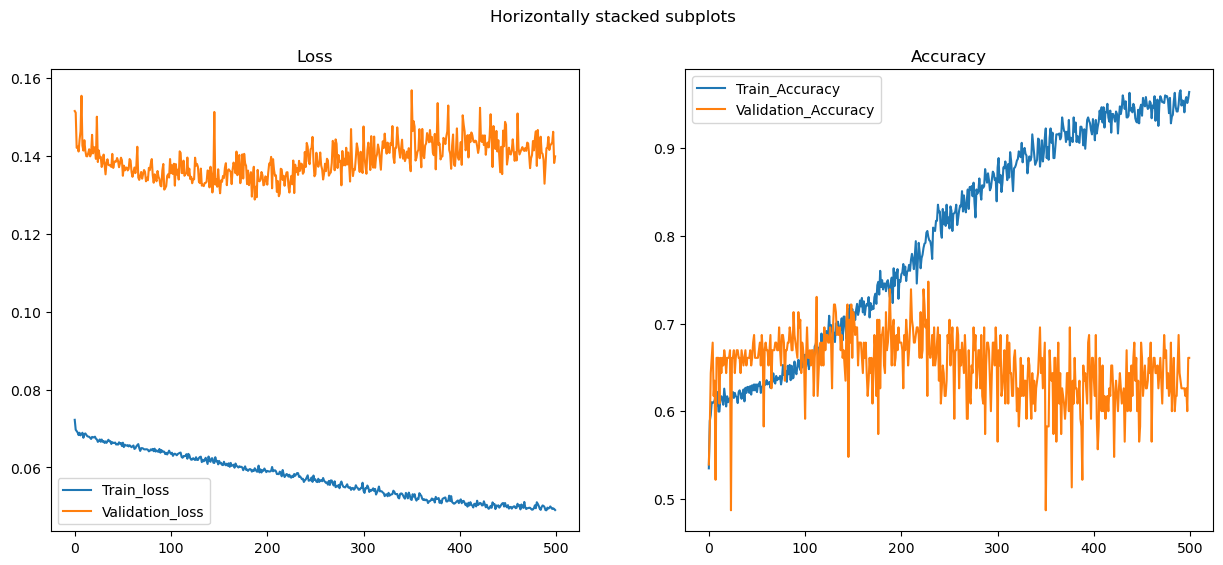

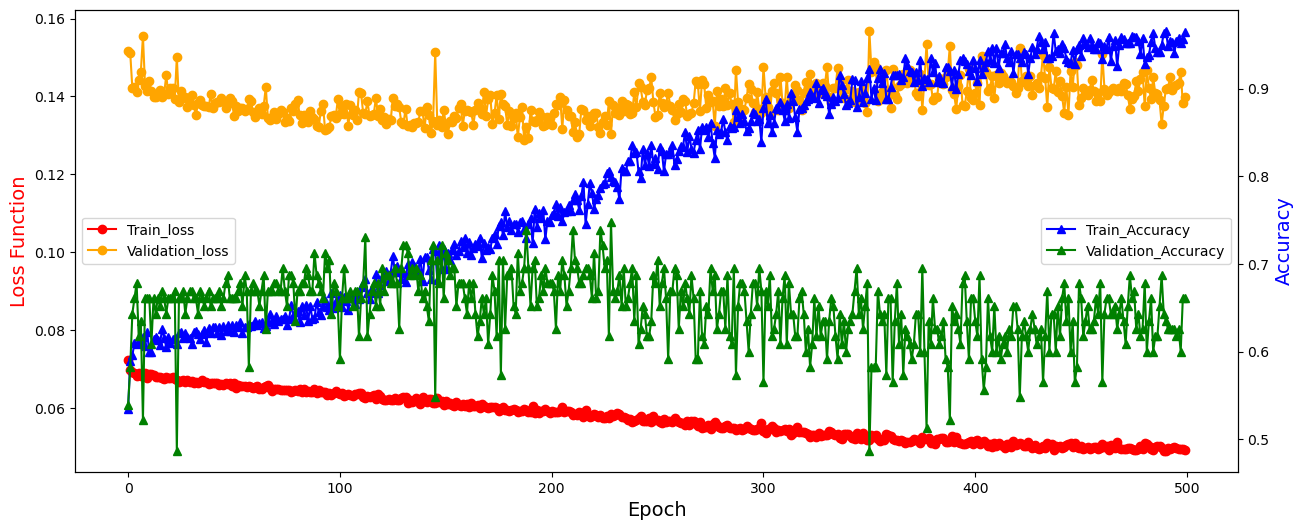

Current time: 367.002 minutes. Time expected till completion: 0.000 minutes
Finished training in: 367.002 minutes


In [14]:
#loader = train_loader # Use the train loader to train
#loader2 = valid_loader
# Main
train_loss, val_loss = [], []
train_accuracy, val_accuracy = [], []

val_loss_withDataAug, val_accuracy_withDataAug = [], []

# Load checkpoints
names = os.listdir(model_checkpoints)
for elem in names:
    if(elem=="metrics_losss_accuracy.csv"):
        print("Loading Metrics")
        dd = pd.read_csv(model_checkpoints + "metrics_losss_accuracy.csv")
        train_loss = dd["train_loss"].tolist()
        val_loss = dd["val_loss"].tolist()
        train_accuracy = dd["train_accuracy"].tolist()
        val_accuracy = dd["val_accuracy"].tolist()
        
# count time
start = time.time()
#PyTorch - Training the Model
for epoch in range(epoch_check, epochs):
    print()
    # Print current epoch
    print(f"Epoch {epoch + 1} of {epochs}")
    
    # Train model
    modelpy.train()
    running_loss=0
    total=0
    correct=0
    # loop for every training batch (one epoch)
    for bi, data in tqdm(enumerate(train_loader), total=len(train_loader)): # use tqdm package to track running time
        # Get the tensors
        images = data[0].to(device)# use the gpu
        labels = data[1].to(device)# use the gpu
        
        # in pytorch you have assign the zero for gradien in any sub epoch
        #optim.zero_grad()
        #create the output from the CNN base on the give batch images
        out = modelpy(images)
        # count the loss function 
        loss = criterion(out, labels)
        
        ######################
        optim.zero_grad()#################
        ######################
        # count the backpropagation
        loss.backward()
        # learning
        optim.step()
        
        # add new value to the main loss
        running_loss += loss.item()
        
        # calculate accuracy
        predictions = torch.argmax(out, dim=1)
        total += labels.size(0)
        correct +=(predictions == labels).sum().item()
        
        
    train_epoch_loss = running_loss/len(train_loader.dataset)
    
    train_epoch_accuracy = correct/total
    
    modelpy.eval()
    running_loss = 0.0
    correct=0
    total=0
    with torch.no_grad():
        for bi, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            # Get the tensors
            images = data[0].to(device)# use the gpu
            label = data[1].to(device)# use the gpu
            
            #create the output from the CNN base on the give batch images
            outputs = modelpy(images)
            # count the loss function
            loss = criterion(outputs, label)
            
            # Add loss of each item (total items in a batch = batch size) .
            running_loss += loss.item()
            
            # calculate accuracy
            predictions = torch.argmax(outputs, dim=1)
            total += label.size(0)
            correct +=(predictions == label).sum().item()
            
            
    val_epoch_loss = running_loss/len(valid_loader.dataset) 
    val_epoch_accuracy = correct/total

    
    
    print("train loss: ", train_epoch_loss)
    print("Val loss: ", val_epoch_loss)
    print("train accuracy: ", train_epoch_accuracy)
    print("Val accuracy: ", val_epoch_accuracy)

    
    
    # save results
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_accuracy.append(val_epoch_accuracy)

    
    # Save model with all information every 100 epochs. Can be used 
    # resuming training. optim
    if (epoch+1) % checkpoints_save == 0: # checkpoints_save
        # Save Model
        print("Saving model checkpoint")
        end = time.time()
        time_elapsed = (end-start)+previous_time
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt.pth")
        # save the metrics
        save_metrics(train_loss, val_loss, train_accuracy, val_accuracy, path = model_checkpoints + "metrics_losss_accuracy.csv")
        
        # save model at epoch
        save_model(epoch, time_elapsed, modelpy, optim, criterion, path = model_checkpoints + "model_ckpt_"+str(epoch+1)+".pth")
        
        # Cheack the evolution at this point
        plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)
        
        
    ep_time = time.time()
    print(f"Current time: {(((ep_time-start)+previous_time)/60):.3f} minutes. Time expected till completion: {(((((ep_time-start)+previous_time)/(epoch + 1)) * (epochs-(epoch + 1)))/60):.3f} minutes")
    
end = time.time()
print(f"Finished training in: {(((end-start)+previous_time)/60):.3f} minutes") 

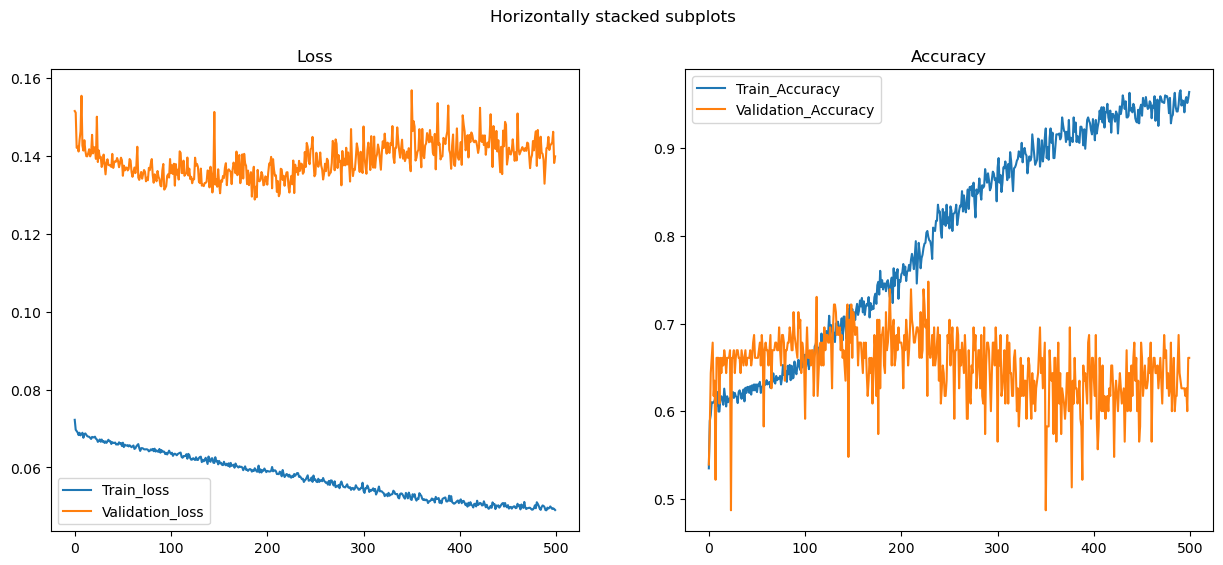

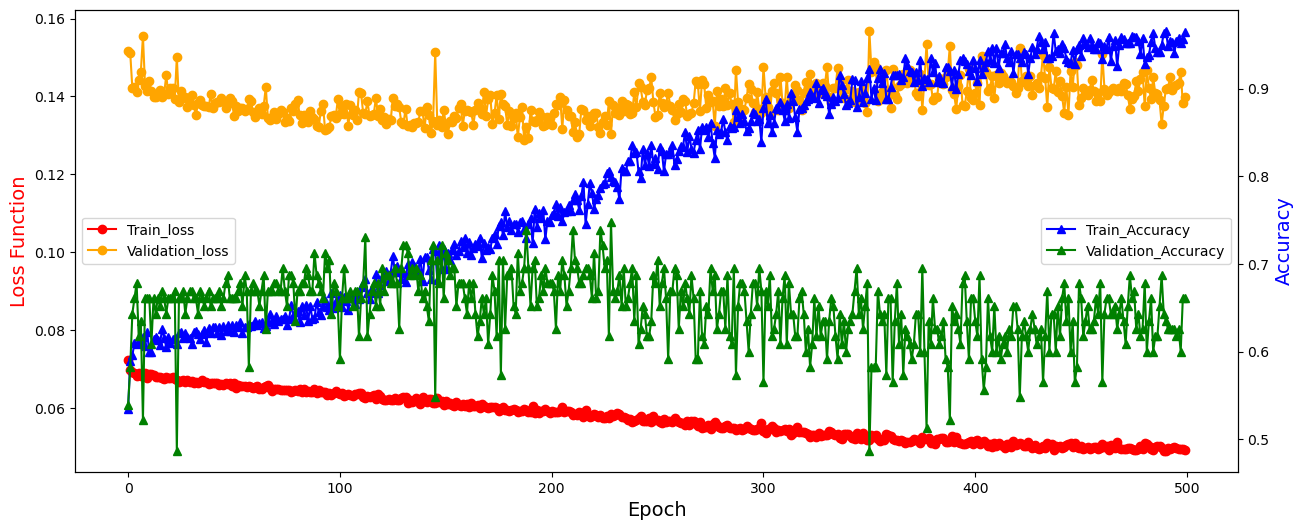

In [15]:
plot_loss_accuracy(train_loss, val_loss, train_accuracy, val_accuracy)

### Save Model

In [16]:
torch.save(modelpy.state_dict(), model_checkpoints + "saved_model_state_dict.pt")
torch.save(modelpy, model_checkpoints + "saved_model.pt")

# 3. Evaluate your model using the developed software

In [17]:
# Calculate accuracy for Validation and Train sets
accuracy_given_set(modelpy, train_loader, device, name="Train")
accuracy_given_set(modelpy, valid_loader, device, name="Validation")

Accuracy of the network on the 1034 Train instances: 97.1953578336557%
Accuracy of the network on the 115 Validation instances: 66.08695652173913%


In [18]:
# Import the test dataset
size_of_resized_img = (224,224) 
test_data, test_names = import_test_folder_dataset_2(test_data_path, resized_side=size_of_resized_img)
print("Dim of Data: ", test_data.shape)
print("Dim of Lables: ", test_names.shape)

Dim of Data:  (380, 224, 224, 3)
Dim of Lables:  (380,)


In [19]:
# Create the dataset object
test_Dataset = Data_test_2(test_data, test_names, img_transform_val)#img_transform_val
print("Test len: ",len(test_Dataset))

Test len:  380


In [20]:
# Make the predictions for the test dataset
predictions_list, names = make_predictions(modelpy=modelpy, dataset=test_Dataset, device=device)
len(predictions_list)

380

In [21]:
# Save the Predictions
save_predictions_as_csv(names=names, predictions=predictions_list, name="14_18Conv_0Res_512FChannels_6Batch.csv")#Conv_Pred_5000Epochs_SGD_DEEP_Architecture_18Conv_4FFNN_HigherChannels.c

# 4. Compare results with [SCTL paper](https://www.mdpi.com/2076-2615/12/7/886/htm). Requirement: performance is better than VGG16: 66.8%

# 5. Write a four-page paper report using the shared LaTex template. Upload your paper to ResearchGate or Arxiv, and put your paper link here.

# 6. Grading rubric

(1). Code ------- 20 points (you also need to upload your final model as a pt file)

(2). Grammer ---- 20 points

(3). Introduction & related work --- 10 points

(4). Method  ---- 20 points

(5). Results ---- 20 points

(6). Discussion - 10 points